# **Use case ML: price prediction of used bikes**

In [1]:
########### Loading in Libs ###########

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve, KFold
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
import joblib
import shutil
import os
import gzip

########### Style for Plots  ###########

plt.style.use('ggplot')

np.int = np.int_ #fix needed for the py version i used

**Table of contents**<a id='toc0_'></a>    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Data Analysis:

In [2]:
df_all_brands = pd.read_pickle("df_all_brands.pkl")

In [3]:
########### Sind irgendwelche Special Editions / Haben Sammlerwert ###########

Z = df_all_brands[df_all_brands['price'] < 50000] 

########### Kategorien ausschließen und richtig zuordnen ###########

Z = Z[~Z['Category'].isin( ["Prototype / concept model", "Scooter", "Unspecified category","Super motard"])]
Z.loc[Z["Category"] == "Cross / motocross", "Category"] = "Enduro / offroad"
Z.loc[Z["Category"] == "Minibike, cross", "Category"] = "Enduro / offroad"
Z.loc[Z["Category"] == "Sport touring", "Category"] = "Touring"

########### Sortieren für das Splitting später ###########

Z = Z.sort_values(by = 'price')
Z = Z.reset_index(drop=True)
Z['price'] = Z['price']*0.92 #in Euro
Z['mileage'] = Z['mileage']*1.60934 #in km

Z = Z.rename(columns = {"mileage":"Mileage [km]", "Displacement (ccm)": "Displacement [ccm]", "Torque (Nm)": "Torque [Nm]", "Power (hp)":"Power [hp]", "Age": "Age [a]"})

########### dealing with categorical features ###########

Z_num = pd.get_dummies(Z, columns=['Brand', 'Condition'], drop_first=True) 

########### Manual Frequency Mapping ###########

freq_Bike = Z_num["Bike"].value_counts().to_dict()
Z_num["Bike"] = Z_num["Bike"].map(freq_Bike)
freq_Cat = Z_num["Category"].value_counts().to_dict()
Z_num["Category"] = Z_num["Category"].map(freq_Cat)

########### Splitting into Attributes and Target ###########

X = Z.drop('price', axis=1) 
y = Z['price']


X_num = Z_num.drop('price', axis=1) 
y_num = Z_num['price']


########### Splitting into different Price Ranges (not used later) ###########

n = int(Z.shape[0] / 5)
Split_Z = [Z[i:i+n].copy() for i in range(0,Z.shape[0],n)]

Z1, Z2, Z3, Z4, Z5 = Split_Z[0], Split_Z[1], Split_Z[2], Split_Z[3], Split_Z[4]
X1, X2, X3, X4, X5 = Z1.drop('price', axis=1), Z2.drop('price', axis=1) , Z3.drop('price', axis=1) , Z4.drop('price', axis=1) , Z5.drop('price', axis=1)
y1, y2, y3, y4, y5 = Z1['price'], Z2['price'], Z3['price'], Z4['price'], Z5['price']

########### Log scaling for cases where i needed the whole dataset ###########

y_log_num = np.log1p(y_num)
y_log = np.log1p(y)
Z


Mileage [km]     price            Bike   Brand         Category  \
0       1931.20800   1283.40     vinoclassic  yamaha          scooter   
1          1.60934   1425.08         tt-r50e  yamaha  minibike, cross   
2          1.60934   1563.08            pw50  yamaha  minibike, cross   
3          3.21868   1563.08            pw50  yamaha  minibike, cross   
4       2414.01000   1564.00           xs650  yamaha          classic   
...            ...       ...             ...     ...              ...   
3427    2655.41100  44150.80     panigalev4r  ducati            sport   
3428     300.94658  44619.08  superleggerav4  ducati       naked bike   
3429     482.80200  45908.00     panigalev4s  ducati            sport   
3430    1689.80700  45995.40  superleggerav4  ducati       naked bike   
3431    9417.85768  45999.08           900ss  ducati            sport   

      Displacement [ccm]  Power [hp]  Torque [Nm]  Condition  Age [a]  
0                  124.0  103.949842    81.543772       True       17  
1                   49.0  103.949842    81.543772      False        1  
2                   49.0    2.700000     3.800000      False        0  
3                   49.0    2.700000     3.800000      False        0  
4                  654.0   50.000000    81.543772       True       41  
...                  ...         ...          ...        ...      ...  
3427               998.0  217.000000   112.000000       True        4  
3428               998.0  221.000000   116.000000       True        9  
3429              1103.0  214.000000   124.000000       True        0  
3430               998.0  221.000000   116.000000       True        9  
3431               864.0   70.000000   108.807294       True       46  

[3432 rows x 10 columns]

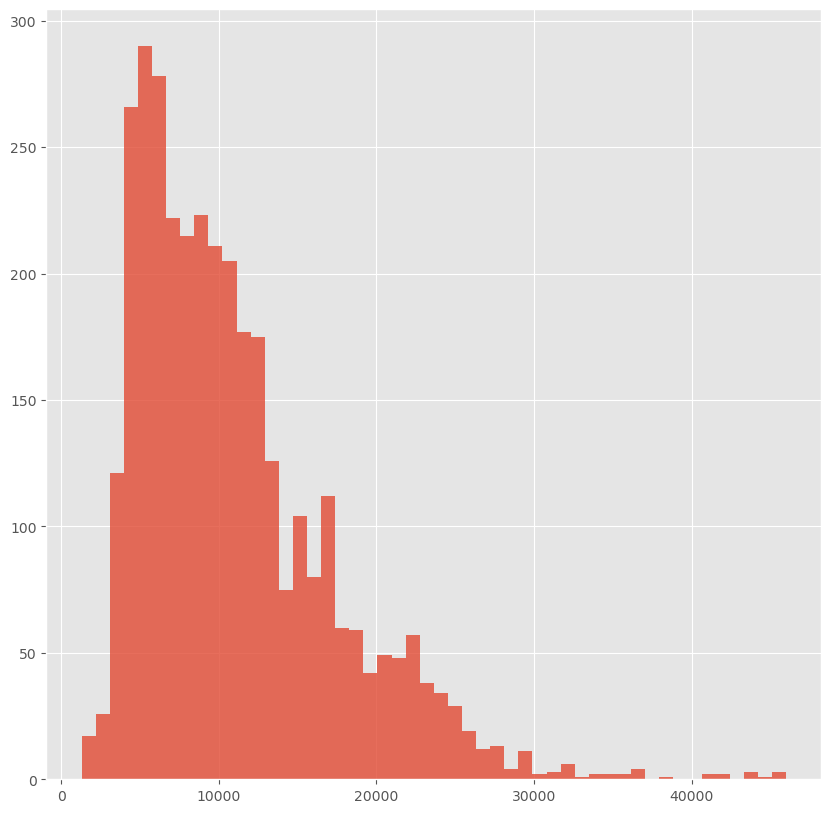

In [4]:
########### Price distribution ###########

y.hist(alpha=0.8, figsize=(10, 10), bins = 50)
plt.show()

/var/folders/zd/qsfm1f5d39ddz1bnq9k3xjwr0000gn/T/ipykernel_17148/3731650136.py:15: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix_plot  = scatter_matrix(X_num.iloc[:, :7],c=y_log_num, alpha=0.8, s=100,  cmap='magma', grid = True, diagonal = 'kde',hist_kwds = {'bins':50}, ax=ax)


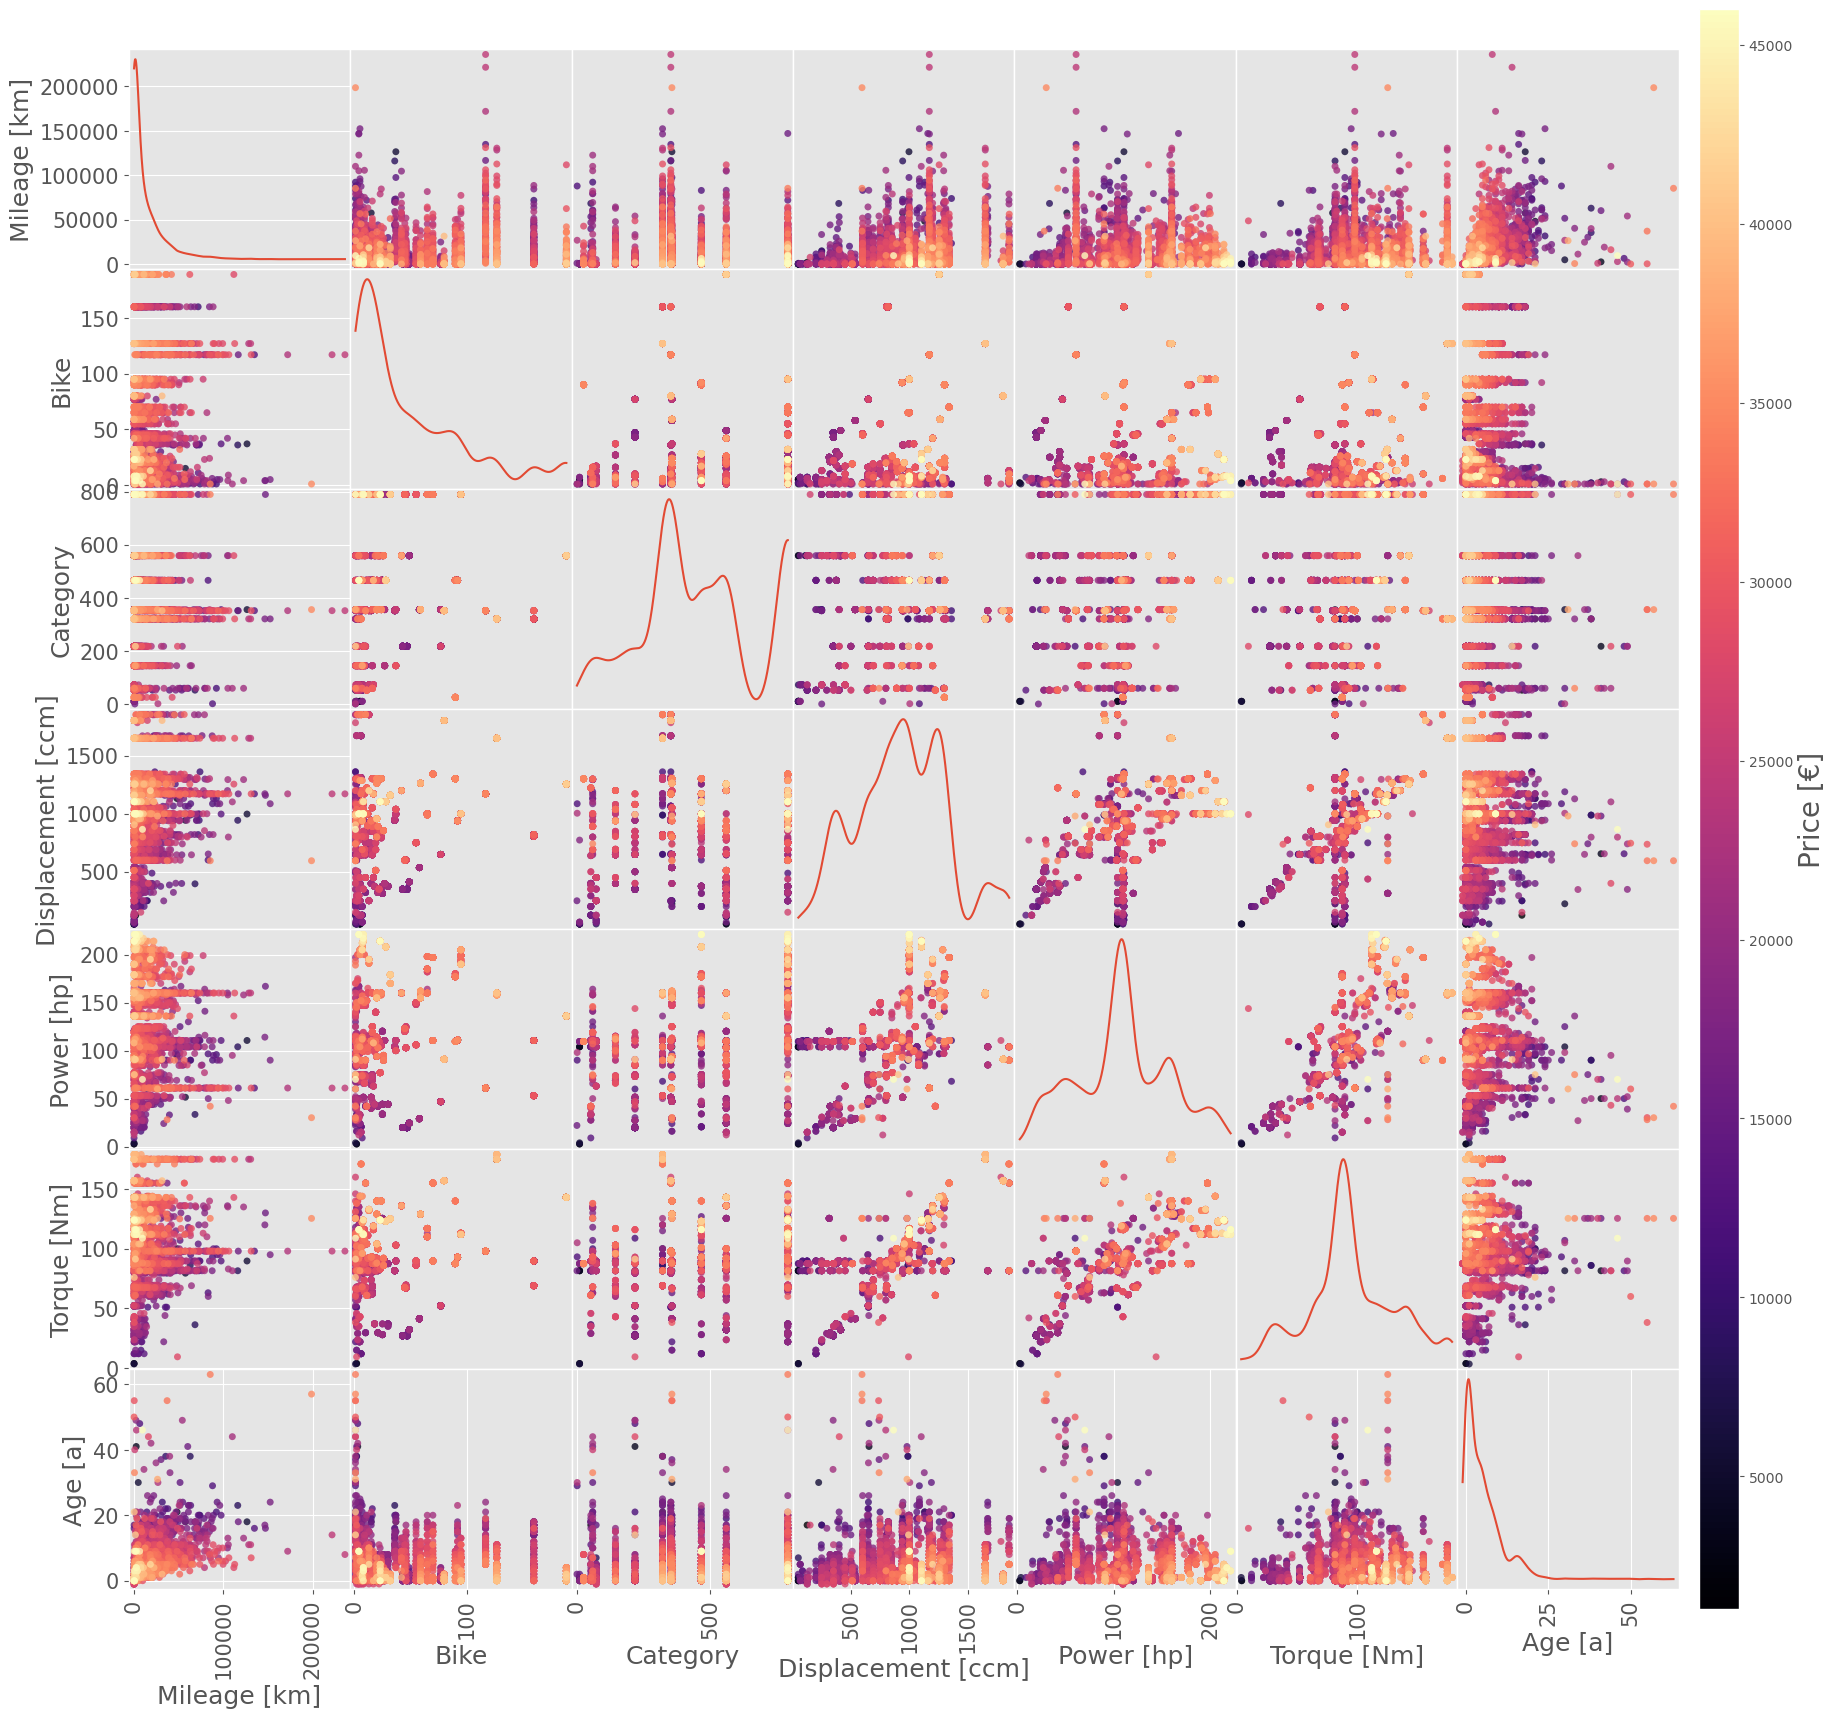

In [5]:
########### Scatter matrix ###########

from pandas.plotting import scatter_matrix
import matplotlib.colors as mcolors

y_mm_num = minmax_scale(y_num, feature_range=(0, 1))
y_log_num = np.log1p(y_num)

plt.rcParams['axes.labelsize'] = 18
fig, ax = plt.subplots(figsize=(20, 20))

cmap = plt.get_cmap('magma')
norm = mcolors.Normalize(vmin=y_num.min(), vmax=y_num.max())

scatter_matrix_plot  = scatter_matrix(X_num.iloc[:, :7],c=y_log_num, alpha=0.8, s=100,  cmap='magma', grid = True, diagonal = 'kde',hist_kwds = {'bins':50}, ax=ax)
plt.subplots_adjust(right=0.9)

for ax1 in scatter_matrix_plot.ravel():
    ax1.tick_params(axis='both', which='major', labelsize=15)

cbar_ax = fig.add_axes([0.91, 0.1, 0.02, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cbar_ax)
cb.set_label('Price [€]', fontsize = 20)

plt.show()

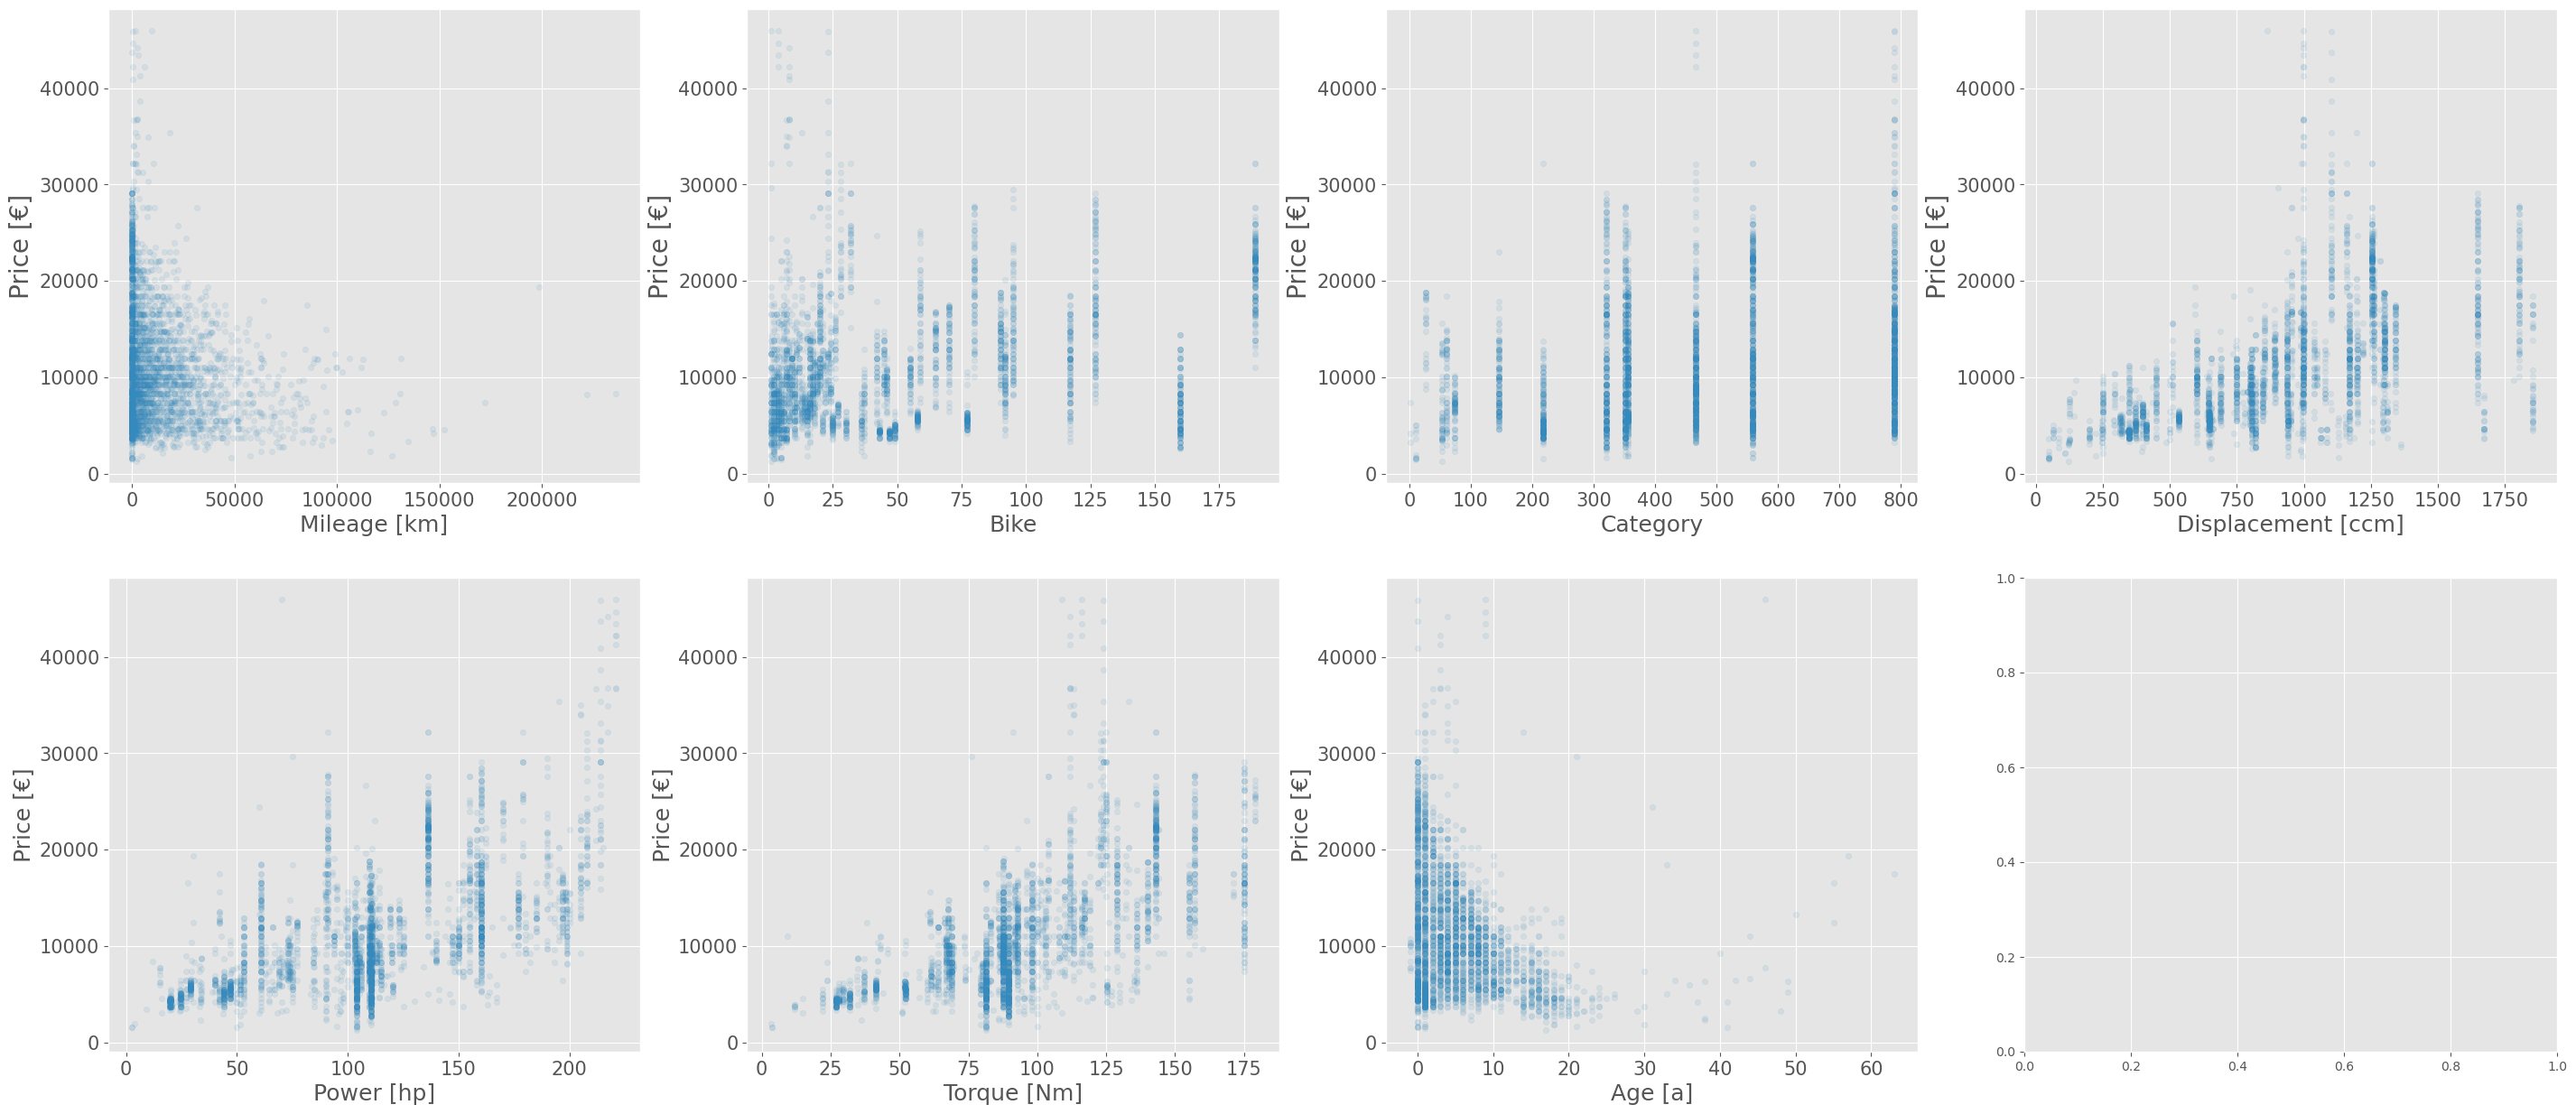

In [6]:
########### scatter plots ###########

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(35,15))


for xcol, ax in zip(['Mileage [km]', 'Bike', 'Category', 'Displacement [ccm]'], axes[0,:]):
    Z_num.plot(kind='scatter', x=xcol, y='price',ax=ax, alpha=0.1,ylabel='Price [€]')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylabel('Price [€]', fontsize=20)

for xcol, ax in zip(['Power [hp]', 'Torque [Nm]', 'Age [a]'], axes[1,:]):
    Z_num.plot(kind='scatter', x=xcol, y='price',ax=ax, alpha=0.1, ylabel='Price [€]')
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

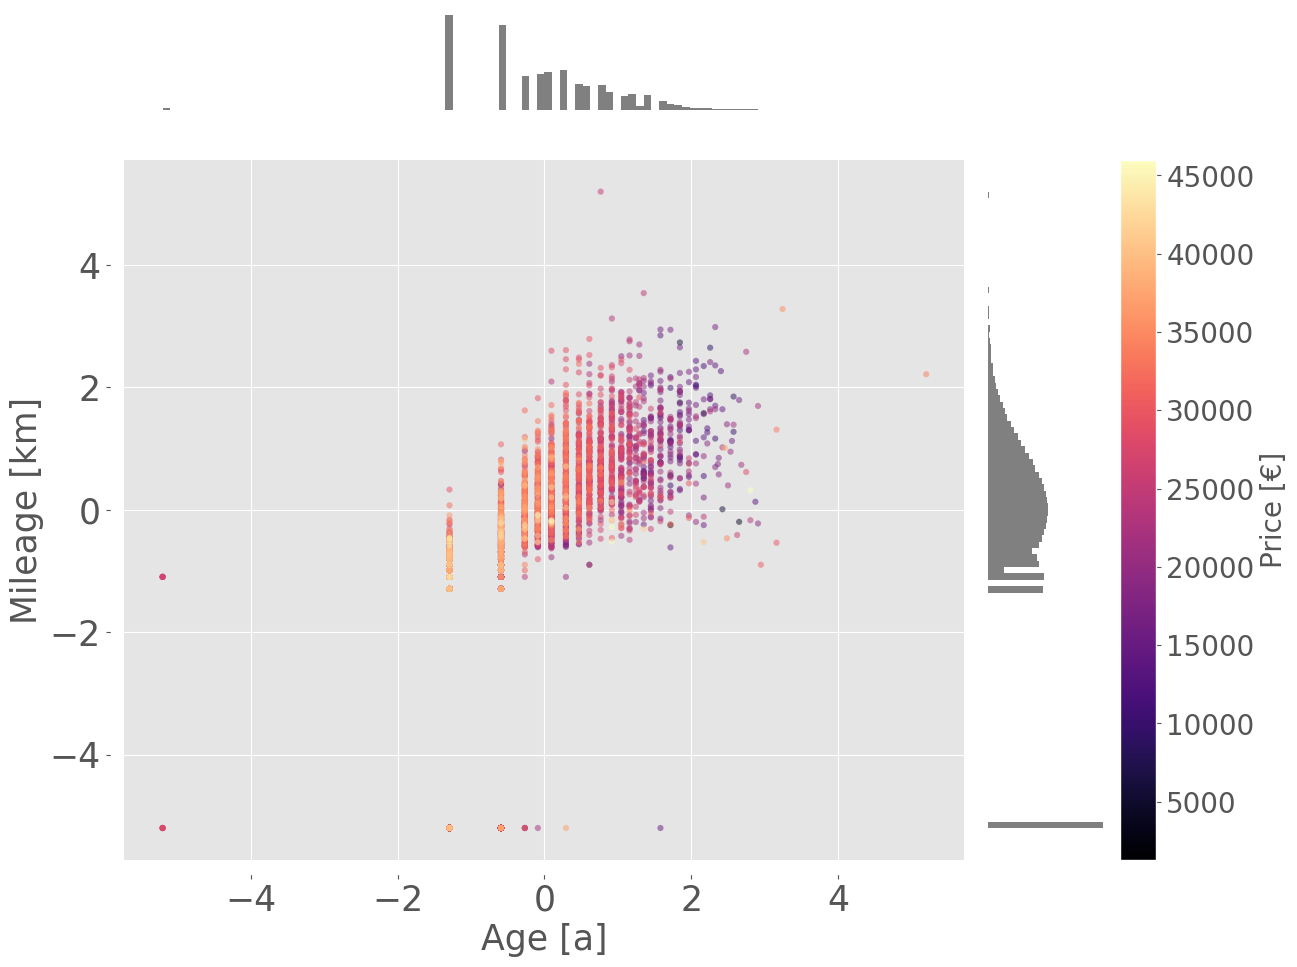

In [7]:
########### Different scalings ###########

X_Standard = StandardScaler().fit_transform(X_num)
X_Standard = MinMaxScaler().fit_transform(X_num)
X_MaxAbs = MaxAbsScaler().fit_transform(X_num)
X_Robust = RobustScaler(quantile_range=(25, 75)).fit_transform(X_num)
X_Uni = QuantileTransformer(output_distribution='uniform').fit_transform(X_num)
X_Normal = QuantileTransformer(output_distribution='normal').fit_transform(X_num)
X_L2 = Normalizer().fit_transform(X_num)

fig = plt.figure(figsize=(12,10))

X_ = X_Normal                        ########### CHANGE THIS FOR DIFFERENT SCALINGS -> X_Standard, X_MaxAbs, X_Robust, X_Uni, X_Normal, X_L2 ###########
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.1]
rect_histy = [left_h, bottom, 0.1, height]

ax_scatter = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

left, width = width + left + 0.13, 0.03

rect_colorbar = [left, bottom, width, height]
ax_colorbar = plt.axes(rect_colorbar)

ax, hist_X1, hist_X0 = ax_scatter, ax_histy, ax_histx

x0_label="Age [a]"
x1_label="Mileage [km]"

ax.set_xlabel(x0_label, fontsize=25)
ax.set_ylabel(x1_label, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax_colorbar.tick_params(axis='both', which='major', labelsize=20)
ax_colorbar.set_ylabel('Price [€]', fontsize=20)

cmap = plt.get_cmap('magma')

ax.scatter(X_[:,6], X_[:,0], alpha=0.5,c=y_log_num,cmap = cmap, marker='o', s=20, lw=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

hist_X1.set_ylim(ax.get_ylim())
hist_X1.hist(X_[:,0], bins=100, orientation='horizontal',
                color='grey', ec='grey')
hist_X1.axis('off')                 

hist_X0.set_xlim(ax.get_xlim())
hist_X0.hist(X_[:,6], bins=100, orientation='vertical',
                color='grey', ec='grey')

hist_X0.axis('off')

norm = mcolors.Normalize(vmin=y_num.min(), vmax=y_num.max())

cb = matplotlib.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              orientation='vertical',
                              label='Price [€]', norm = norm)

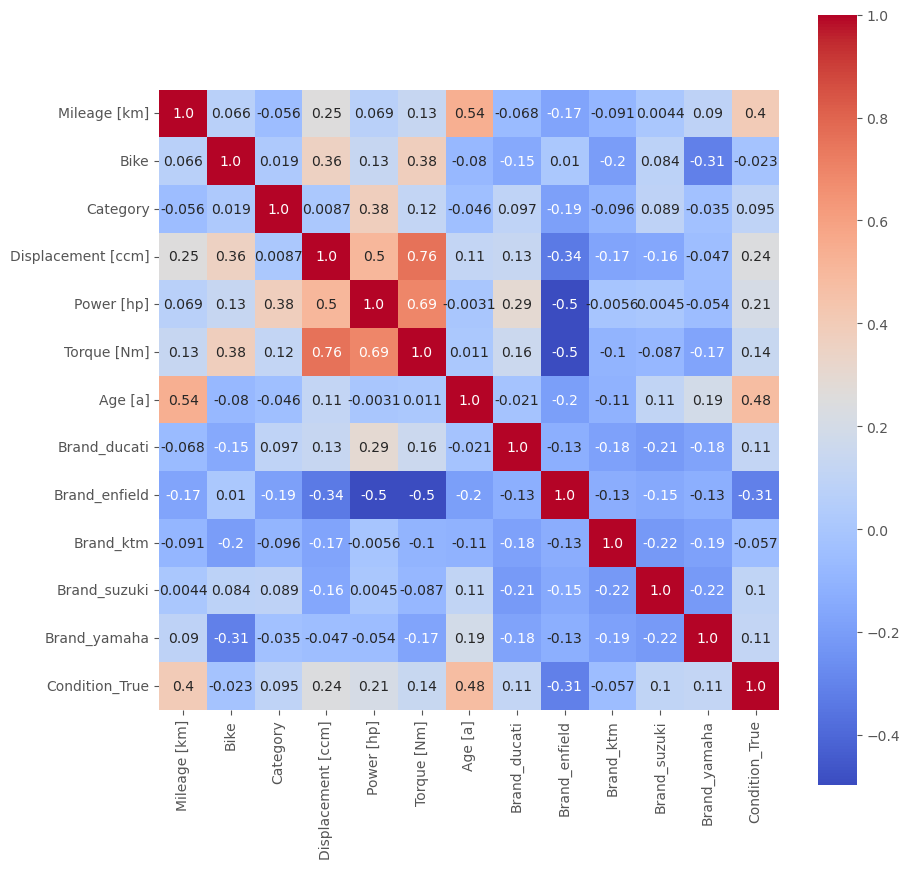

In [8]:
########### Correlation matrix ###########

Z_temp = X_num[:]
plt.figure(figsize=(10,10))
sns.heatmap(data = Z_temp.iloc[:].corr(), annot=True, square=True, cmap='coolwarm', label='Correlation', fmt=".2")
plt.show()

## **Machine Learning:**

### Scalers, Transformers and Pipelines:

In [9]:
########### Numerical and Categorical Features ###########

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_ = X.select_dtypes(include=['object', 'string[python]', 'bool']).columns.tolist()

########### Preprocessing for numerical data ###########

num_transformer_std = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

num_transformer_norm = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', QuantileTransformer(output_distribution='normal'))
])

num_transformer_robust = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler(quantile_range=(25, 75)))
])

num_transformer_none = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

########### Preprocessing for categorical data ###########

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#For CatBoost
cat_transformer_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))]) 

########### Define different preprocessors for numerical data ##########

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', num_transformer_std, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_norm = ColumnTransformer(
    transformers=[
        ('num', num_transformer_norm, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_robust = ColumnTransformer(
    transformers=[
        ('num', num_transformer_robust, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_none = ColumnTransformer(
    transformers=[
        ('num', num_transformer_none, num_features),
        ('cat', cat_transformer, cat_features_)
    ])

#For CatBoost

preprocessor_none_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_none, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_std_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_std, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_norm_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_norm, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_robust_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_robust, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

########### Transformer for the Price ###########

target_transformer_log = FunctionTransformer(np.log1p,inverse_func=np.expm1, validate=True)
target_transformer_mm = MinMaxScaler()

### Train - Test Split:

In [10]:
########### Train - Test - Splitting ###########

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

########### Log Transformation ###########

y_train_log = target_transformer_log.fit_transform(y_train.values.reshape(-1, 1))
y_test_log = target_transformer_log.transform(y_test.values.reshape(-1, 1))

y_train_mm = target_transformer_mm.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)
y_test_mm = target_transformer_mm.transform(y_test.values.reshape(-1, 1)).reshape(-1)

########### Define Scorers for the Cross validation ###########

def rmsle_score(y_true, y_pred):
    #y_true = target_transformer_mm.inverse_transform(y_true.reshape(-1, 1)).reshape(-1)  ########### SWITCH IF MIN MAX SCALING IS USED INSTEAD OF LOG ###########
    #y_pred = target_transformer_mm.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))
def mse_score(y_true, y_pred):
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return mean_squared_error(y_true, y_pred)
def mae_score(y_true, y_pred):
    y_true = np.expm1(y_true)  
    y_pred = np.expm1(y_pred)
    return mean_absolute_error(y_true, y_pred)
def r2_score1(y_true, y_pred):
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return r2_score(y_true, y_pred)

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)
r2_scorer = make_scorer(r2_score1, greater_is_better=False)
mse_scorer = make_scorer(mse_score, greater_is_better=False)
mae_scorer = make_scorer(mae_score, greater_is_better=False)

########### KFold for Cross Validation ###########

kf = KFold(n_splits=10, shuffle=True, random_state=123)

### **Training Models:**

#### **XGBOOST TREE**

In [11]:
########### Define Parameter Grid ###########

param_grid_xgbtree = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__learning_rate': [0.03, 0.05, 0.08],
    'regressor__max_depth': [4, 5, 6],
    'regressor__min_child_weight': [2, 3, 4],
    'regressor__subsample': [0.4, 0.6, 0.7],
    'regressor__colsample_bytree': [0.3, 0.6, 0.8],
    'regressor__gamma': [0, 0.1, 0.3, 0.5],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1]
}


########### Initialize Base Model ###########

xgb_tree_model = XGBRegressor(objective='reg:squarederror', booster='gbtree', random_state=42, enable_categorical=True)

########### Use Pipeline on Base Model ###########

model_xgbtree = Pipeline(steps=[
    ('preprocessor', preprocessor_norm),  ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', xgb_tree_model)
])

########### Random Search for best parameters ###########

#random_search_xgbtree = RandomizedSearchCV(estimator=model_xgbtree, param_distributions=param_grid_xgbtree, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_xgbtree.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_xgbtree_std_log = {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_norm_log = {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_robust_log = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_none_log = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_std_mm = {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.01, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_xgbtree = best_params_xgbtree_norm_log
#random_search_xgbtree.best_params_ ########### Parameters of Grid Search

########### Set Parameters ###########

best_xgbtree = model_xgbtree.set_params(**best_params_xgbtree)
start = time.time() ########### Track Time
best_xgbtree.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_xgbtree = best_xgbtree.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_xgbtree_inv = target_transformer_log.inverse_transform(y_pred_xgbtree.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########
 
cv_scores_xgbtree_rmsle = cross_val_score(best_xgbtree, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for XGBoost Tree: ")
print(f"Best parameters: {best_params_xgbtree}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgbtree_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgbtree_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgbtree_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgbtree_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgbtree_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgbtree))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Tree: 
Best parameters: {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
Cross-Validation RMSE Scores: [1921.50438699 2074.87841595 2975.03437774 2421.60650557 2015.18484966
 1885.90710725 1823.46849886 2204.11743627 2482.65765435 2138.35401183]
Mean RMSE: 2194.2713244467923
Standard Deviation of RMSE: 331.8093213190449
MSE: 7087671.53
MAE: 1488.82
R2-Score: 0.868
Training time: 1.4668960571289062s


##### **XGBoost Metrics:**

**Metrics for XGBoost Tree Log Standard:**

Best parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2112.02973138 3359.98328441 2116.63709523 2258.95546336 2534.21538524 2075.57920921 2803.52390877 2532.2391268  2469.95961849 1741.7229471 ]

Mean RMSE: 2400.48

Standard Deviation of RMSE: 429.71

MSE: 4557951.89

MAE: **1350.62**

R2-Score: **0.894**

Training time: 2.37s


**Metrics for XGBoost Tree Log Normalised: (BEST)**

Best parameters: {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2161.23741596 3322.02786192 2137.90912851 2315.7989309  2587.76970711 2112.66001255 2676.10762662 2330.87051486 2369.97988735 1778.2157678 ]

Mean RMSE: 2379.26

Standard Deviation of RMSE: 395.60

MSE: 4514569.40

MAE: **1352.13**

R2-Score: **0.897**

Training time: 2.42s


**Metrics for XGBoost Tree Robust:**

Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2085.10909863 3393.07532792 2223.32343396 2414.82424385 2626.12583229 2026.79056983 2698.34018201 2447.40098379 2373.95324535 1760.78647443]

Mean RMSE: 2404.97

Standard Deviation of RMSE: 425.15

MSE: 4500529.41

MAE: **1356.10**

R2-Score: **0.895**

Training time: 2.71


**Metrics for XGBoost Tree Log No Scaling:**

Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2075.83261461 3322.12092512 2164.67377904 2332.07881493 2616.94182646 2014.93333682 2721.03162476 2500.56481784 2381.85544236 1762.41658875]

Mean RMSE: 2389.245

Standard Deviation of RMSE: 415.883

MSE: 4479635.33

MAE: **1342.35**

R2-Score: **0.897**

Training time: 2.351s


**Metrics for XGBoost Tree MM Standard:**

Best parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.01, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2288.1187393  3436.89222874 2219.56272654 1924.27277691 2685.30148106 2146.61733512 2622.66234688 2507.47615984 2729.01564972 2307.90476099]

Mean RMSE: 2486.78

Standard Deviation of RMSE: 399.34

MSE: 4706014.85

MAE: **1447.28**

R2-Score: **0.878**

Training time: 5.20

In [12]:
print(best_xgbtree.named_steps['regressor'])

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


#### **XGBOOST LIN**

In [13]:
########### Define Parameter Grid ###########

param_grid_xgblin = {
    'regressor__learning_rate': [0.06, 0.08, 0.1, 0.12],
    'regressor__alpha': [1.3, 1.5, 1.7],
    'regressor__lambda': [0.001, 0.1, 1],
    'regressor__n_estimators': [300, 320, 349],
    'regressor__reg_alpha': [0, 0.001, 0.01],
    'regressor__reg_lambda': [0.003, 0.005, 0.01]
}

########### Initialize Base Model ###########

xgb_lin_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=50)

########### Use Pipeline on Base Model ###########

model_xgblin = Pipeline(steps=[
    ('preprocessor', preprocessor_none), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', xgb_lin_model)
])

########### Random Search for best parameters ###########

#random_search_xgblin = RandomizedSearchCV(estimator=model_xgblin, param_distributions=param_grid_xgblin, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_xgblin.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_xgblin_std_log = {'regressor__reg_lambda': 0.005, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.001, 'regressor__alpha': 1.5}
best_params_xgblin_norm_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}
best_params_xgblin_robust_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}
best_params_xgblin_none_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}
#random_search_xgblin.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_xgblin = best_params_xgblin_none_log

########### Set Parameters ###########

best_xgblin = model_xgblin.set_params(**best_params_xgblin)
start = time.time()
best_xgblin.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_xgblin = best_xgblin.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_xgblin_inv = target_transformer_log.inverse_transform(y_pred_xgblin.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_xgblin_rmsle = cross_val_score(best_xgblin, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for XGBoost Lin: ")
print(f"Best parameters: {best_params_xgblin}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgblin_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgblin_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgblin_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgblin_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgblin_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgblin))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Lin: 
Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}
Cross-Validation RMSE Scores: [2262.86506917 3590.03898699 3571.65906594 3387.79814334 2548.31571073
 3079.42495035 2620.97325147 4128.94705575 3092.24007896 3039.31999379]
Mean RMSE: 3132.1582306497776
Standard Deviation of RMSE: 532.2218959755734
MSE: 11734572.30
MAE: 2063.73
R2-Score: 0.731
Training time: 1.2552869319915771s


##### **XGBOOST LIN METRICS:**

**Metrics for XGBoost Lin Standard:**

Best parameters: {'regressor__reg_lambda': 0.005, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.001, 'regressor__alpha': 1.5}

Cross-Validation RMSE Scores: [2875.92350078 3813.3397601  3527.17262871 3599.8244191  3509.00374465 2826.62478785 3840.11190907 3346.20591247 4341.02300559 2708.38487218]

Mean RMSE: 3438.76

Standard Deviation of RMSE: 488.64

MSE: 8740382.35

MAE: **1920.28**

R2-Score: **0.783**

Training time: 2.37s


**Metrics for XGBoost Lin Normalised:**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}

Cross-Validation RMSE Scores: [2978.67539117 3831.7430115  3583.40216116 3240.15981843 3411.10240912 2844.63171407 3608.77164637 3248.2082167  3841.29823349 2905.98954913]

Mean RMSE: 3349.40

Standard Deviation of RMSE: 348.06

MSE: 9572071.25

MAE: **2082.50**

R2-Score: **0.765**

Training time: 2.45s

**Metrics for XGBoost Lin Robust: (BEST)**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}

ross-Validation RMSE Scores: [3135.96235869 3812.42318278 3587.86662636 3384.04775868 3606.06094928 2650.43955494 3930.40119147 3443.79756281 4347.24998711 2709.42401445]

Mean RMSE: 3460.77

Standard Deviation of RMSE: 500.02

MSE: 8402075.27

MAE: **1915.19**

R2-Score: **0.787**

Training time: 3.43

**Metrics for XGBoost Lin No Scaling:**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}

Cross-Validation RMSE Scores: [2838.05481834 3924.09805536 3583.14428551 3579.86077855 3657.67248474 2675.76984055 3788.55376952 3417.78301586 4226.34412204 2749.16816792]
 
Mean RMSE: 3444.05

Standard Deviation of RMSE: 498.56

MSE: 9371909.08

MAE: **2027.86**

R2-Score: **0.764**

Training time: 2.54s


#### **CatBoost:**

In [14]:
########### Define Parameter Grid ###########

param_grid_catboost = {
    'regressor__iterations': [500, 1000],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__depth': [4, 6, 8, 10],
    'regressor__l2_leaf_reg': [1, 3, 5, 7],
    'regressor__bagging_temperature': [0.5, 1],
    'regressor__random_strength': [0.05, 1, 5],
    'regressor__border_count': [32, 64, 128],
    'regressor__min_data_in_leaf': [1, 3, 10],
    'regressor__one_hot_max_size': [2, 10, 20]
}

########### Index of Cat features after preprocessor ###########

cat_features__ = [5, 6, 7, 8]

########### Initialize Base Model ###########

catboost_model = CatBoostRegressor(random_seed=42, cat_features= cat_features__)

########### Use Pipeline on Base Model ###########

model_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor_std_cat), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('regressor', catboost_model)
])

########### Random Search for best parameters ###########

#random_search_catboost = RandomizedSearchCV(estimator=model_catboost.set_params(regressor__cat_features= cat_features__), param_distributions=param_grid_catboost, cv=kf, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

########### Fitting for Randomized Search ###########

#random_search_catboost.fit(X_train, y_train_log, regressor__cat_features= cat_features__)

########### Best Parameters from Search ###########

best_params_catboost_std_log = {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 10, 'regressor__min_data_in_leaf': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
best_params_catboost_norm_log = {'regressor__random_strength': 0.05, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 6, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.5}
best_params_catboost_robust_log = {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}
best_params_catboost_none_log =  {'regressor__random_strength': 5, 'regressor__one_hot_max_size': 20, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.05, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
#random_search_catboost.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_catboost = best_params_catboost_std_log

########### Set Parameters ###########

best_catboost = model_catboost.set_params(**best_params_catboost,)

start = time.time()
best_catboost.fit(X_train, y_train_log, regressor__cat_features =cat_features__) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_catboost = best_catboost.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_catboost_inv = target_transformer_log.inverse_transform(y_pred_catboost.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_catboost_rmsle = cross_val_score(best_catboost, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for CatBoost: ")
print(f"Best parameters: {best_params_catboost}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_catboost_rmsle}")
print(f"Mean RMSE: {-cv_scores_catboost_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_catboost_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_catboost_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_catboost_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_catboost))
print(f"Training time: {stop - start}s")

0:	learn: 0.5203376	total: 62.4ms	remaining: 31.1s
1:	learn: 0.4868532	total: 63.9ms	remaining: 15.9s
2:	learn: 0.4585872	total: 65.2ms	remaining: 10.8s
3:	learn: 0.4334838	total: 66.6ms	remaining: 8.26s
4:	learn: 0.4104279	total: 68.1ms	remaining: 6.74s
5:	learn: 0.3890230	total: 69.2ms	remaining: 5.7s
6:	learn: 0.3714713	total: 70.5ms	remaining: 4.96s
7:	learn: 0.3549587	total: 71.9ms	remaining: 4.42s
8:	learn: 0.3392195	total: 73.6ms	remaining: 4.01s
9:	learn: 0.3248954	total: 74.7ms	remaining: 3.66s
10:	learn: 0.3133482	total: 76ms	remaining: 3.38s
11:	learn: 0.3023295	total: 77.2ms	remaining: 3.14s
12:	learn: 0.2921142	total: 78.5ms	remaining: 2.94s
13:	learn: 0.2838602	total: 79.6ms	remaining: 2.76s
14:	learn: 0.2758625	total: 80.8ms	remaining: 2.61s
15:	learn: 0.2687615	total: 82ms	remaining: 2.48s
16:	learn: 0.2616599	total: 83.3ms	remaining: 2.37s
17:	learn: 0.2561220	total: 84.5ms	remaining: 2.26s
18:	learn: 0.2497449	total: 85.7ms	remaining: 2.17s
19:	learn: 0.2442017	total:

##### METRICS CATBOOST:

**Metrics for Catboost Log Standard (BEST):**

Best parameters: {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 10, 'regressor__min_data_in_leaf': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}

Cross-Validation RMSE Scores: [2054.22396583 3185.68220274 2242.48420856 2270.15758479 2503.43829942 2013.0169515  2588.78605261 2517.41866886 2302.57048513 1663.35454145]

Mean RMSE: 2334.11

Standard Deviation of RMSE: 386.93

MSE: 4146873.05

MAE: **1297.27**

R2-Score: **0.902**

Training time: 2.15

**Metrics for Catboost Normalised:** 

Best parameters: {'regressor__random_strength': 0.05, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 6, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.5}

Cross-Validation RMSE Scores: [2159.76198192 3140.28206616 2155.62470872 2092.91998605 2474.50740455 1957.51152263 2496.91183554 2524.20096755 2319.4981183  1662.72679045]

Mean RMSE: 2298.39

Standard Deviation of RMSE: 378.51

MSE: 4407888.22

MAE: **1320.62**

R2-Score: **0.899**

Training time: 1.73s

**Metrics for Catboost Robust:**

Best parameters: {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}

Cross-Validation RMSE Scores: [2206.89994378 3158.02482086 2264.00659475 2098.50868624 2690.36732593 1967.90998071 2480.77836633 2525.8082817  2406.77617059 1640.11327456]

Mean RMSE: 2343.92

Standard Deviation of RMSE: 395.05

MSE: 4174227.18

MAE: **1305.89**

R2-Score: **0.899**

Training time: 2.51s

**Metrics for Catboost No Scaling:** 

Best parameters: {'regressor__random_strength': 5, 'regressor__one_hot_max_size': 20, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.05, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
Cross-Validation RMSE Scores: [2007.58404541 3276.55882292 2087.87444843 2051.36170411 2515.72346317 2045.67003296 2599.41770193 2460.58616417 2361.81591538 1693.02003295]

Mean RMSE: 2309.96

Standard Deviation of RMSE: 417.60

MSE: 4148775.54

MAE: **1300.41**

R2-Score: **0.901**

Training time: 1.81s

#### **ADABOOST:**

In [15]:
########### Define Parameter Grid ###########

param_grid_adatree = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 1],
    'regressor__estimator__max_depth': [1, 2, 3]}

########### Initialize Base Model ###########

base_model = DecisionTreeRegressor()
ada_tree_model = AdaBoostRegressor(estimator=base_model, random_state=42, loss ='exponential')

########### Use Pipeline on Base Model ###########

model_adatree = Pipeline(steps=[
    ('preprocessor', preprocessor_none), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', ada_tree_model)
])

########### Random Search for best parameters ###########

#random_search_adatree = RandomizedSearchCV(estimator=model_adatree, param_distributions=param_grid_adatree, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_adatree.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_adatree_std_log = {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_norm_log = {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_robust_log = {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_none_log = {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
#random_search_adatree.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_adatree = best_params_adatree_none_log

########### Set Parameters ###########

best_adatree = model_adatree.set_params(**best_params_adatree)
start = time.time()
best_adatree.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_adatree = best_adatree.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_adatree_inv = target_transformer_log.inverse_transform(y_pred_adatree.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_adatree_rmsle = cross_val_score(best_adatree, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for AdaBoost: ")
print(f"Best parameters: {best_params_adatree}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_adatree_rmsle}")
print(f"Mean RMSE: {-cv_scores_adatree_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_adatree_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_adatree_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_adatree_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_adatree))
print(f"Training time: {stop - start}s")

Metrics for AdaBoost: 
Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
Cross-Validation RMSE Scores: [2930.31477696 3466.72101371 3609.38766868 3514.42596671 2789.45016935
 3213.17342304 3198.46113157 3719.99017322 3367.49698796 3564.69001131]
Mean RMSE: 3337.4111322500685
Standard Deviation of RMSE: 286.65046206694075
MSE: 13101465.36
MAE: 2464.86
R2-Score: 0.736
Training time: 1.7610671520233154s


##### **ADABOOST METRICS:**

**Metrics for AdaBoost Tree Log Standard:** 

Best parameters: {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3095.99922263 3755.09487152 3311.82332674 3623.61666092 3625.9379629 3167.97207058 4168.57773347 3750.19046947 4385.82384339 2945.78789522]

Mean RMSE: 3583.08

Standard Deviation of RMSE: 440.17

MSE: 10952648.28

MAE: **2337.28**

R2-Score: **0.768**

Training time: 2.62s

**Metrics for AdaBoost Tree Log Normalised: (BEST)** 

Best parameters: {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [2957.28343312 3755.84203139 3323.35389333 3491.85800767 3591.22256778 3188.35036614 4098.92760647 3786.8502023  4267.29447033 2940.70727812]

Mean RMSE: 3540.17

Standard Deviation of RMSE: 426.98

MSE: 11411895.78

MAE: **2325.36**

R2-Score: **0.767**

Training time: 2.54s

**Metrics for AdaBoost Tree Log Robust:** 

Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3157.30278356 3789.27792427 3395.26796872 3691.11138487 3626.3725542 3174.04872236 4360.58018463 3758.99854509 4354.39070176 3197.1272112 ]

Mean RMSE: 3650.45

Standard Deviation of RMSE: 421.17

MSE: 11127472.68

MAE: **2370.37**

R2-Score: **0.762**

Training time: 3.22

**Metrics for AdaBoost Tree No Scaling:** 

Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3172.62841034 3908.32059859 3317.08896478 3634.51874029 3593.65254522 3147.55785325 4382.87224401 3805.52471023 4334.8678519  2967.82287387]

Mean RMSE: 3626.49

Standard Deviation of RMSE: 463.84

MSE: 11975364.10

MAE: **2421.71**

R2-Score: **0.751**

Training time: 2.86s

#### **EXTRA TREES**

In [16]:
########### Define Parameter Grid ###########

param_grid_ET = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
    #'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

########### Initialize Base Model ###########

extra_trees_regressor = ExtraTreesRegressor(random_state=42, bootstrap = True, max_features = 'log2')

########### Use Pipeline on Base Model ###########

model_et = Pipeline(steps=[
    ('preprocessor', preprocessor_robust), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', extra_trees_regressor)
])

########### Random Search for best parameters ###########

#random_search_et = RandomizedSearchCV(estimator=model_et, param_distributions=param_grid_ET, n_iter=200, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_et.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_et_std_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
best_params_et_norm_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 30}
best_params_et_robust_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
best_params_et_none_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}
#random_search_et.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_et = best_params_et_robust_log

########### Set Parameters ###########

best_et = model_et.set_params(**best_params_et)
start = time.time()
best_et.fit(X_train, y_train_log.ravel())  ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_et = best_et.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_et_inv = target_transformer_log.inverse_transform(y_pred_et.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_et_rmsle = cross_val_score(best_et, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########
print("Metrics for Extra Trees: ")
print(f"Best parameters: {best_params_et}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_et_rmsle}")
print(f"Mean RMSE: {-cv_scores_et_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_et_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_et_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_et_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_et))
print(f"Training time: {stop - start}s")

Metrics for Extra Trees: 
Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
Cross-Validation RMSE Scores: [1652.23607557 2222.6952605  2995.16218736 2491.3488275  2099.88578632
 1930.27823023 1944.88908559 2626.73537888 2467.17647853 2223.92636746]
Mean RMSE: 2265.433367794293
Standard Deviation of RMSE: 371.0559623414874
MSE: 7054641.38
MAE: 1490.44
R2-Score: 0.863
Training time: 1.81516695022583s


##### EXTRA TREES METRICS:

**Metrics for Extra Tree Log Standard:**

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

Cross-Validation RMSE Scores: [2232.01337882 3424.82983704 2412.39290284 2451.24930626 2512.36167334 2079.55354287 2787.69893628 2530.17626057 2672.5654003  1842.8446666 ]

Mean RMSE: 2494.57

Standard Deviation of RMSE: 407.32

MSE: 4481129.52

MAE: **1349.45**

R2-Score: **0.889**

Training time: 3.47s

**Metrics for Extra Tree Log Normalised:** 

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 30}

Cross-Validation RMSE Scores: [2248.18737597 3403.90449366 2411.22516908 2532.23084757 2523.01533853 2152.76242567 2841.59419393 2546.08601446 2546.59697768 1864.03075091]

Mean RMSE: 2506.96

Standard Deviation of RMSE: 391.85

MSE: 4426545.16

MAE: **1357.27**

R2-Score: **0.886**

Training time: 3.47s

**Metrics for Extra Tree Log Robust: (BEST)**

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

Cross-Validation RMSE Scores: [2234.87335067 3425.79842625 2401.25712544 2396.36577456 2507.45672722 2066.67180223 2783.59600359 2525.73859772 2536.13462763 1821.82190257]

Mean RMSE: 2469.97

Standard Deviation of RMSE: 408.54

MSE: 4394657.34

MAE: **1339.02**

R2-Score: **0.890**

Training time: 3.76

**Metrics for Extra Tree Log No Scaling:** 

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}

Cross-Validation RMSE Scores: [2276.57774037 3527.9864219  2411.34020842 2365.66351731 2746.04872753 2146.28303406 2725.95728645 2508.91628507 2677.95911865 1791.22241392]

Mean RMSE: 2517.80

Standard Deviation of RMSE: 435.92

MSE: 4590153.21

MAE: **1369.69**

R2-Score: **0.891**

Training time: 3.94s


#### ENSEMBLE CATBOOST, XGBOOST, EXTRA TREES

In [17]:
########### Define Ensemble ###########

ensemble_model = VotingRegressor(estimators=[('CatBoost',best_catboost ),('ExtraTrees', best_et), ('XGBoost', best_xgbtree)])

In [18]:
########### Search for Best Weights ###########

params_weights = {
          'weights':[(1,1,1), (1,1,2), 
                     (2,1,1), (1,2,1),
                     (2,2,1), (1,2,2), 
                     (1,2,3), (3,2,1),
                     (2,3,1), (1,3,2)]}

#grid = GridSearchCV(ensemble_model, params_weights, n_jobs = -1, cv=kf, verbose=2, scoring='neg_mean_squared_error')
#grid.fit(X_train, y_train_log.ravel())

best_params_ = {'weights': (2, 1, 1)} ########### Best weights ###########

########### Set Parameters ###########

tuned_ensemble_model = VotingRegressor(estimators=[('CatBoost',best_catboost ),('ExtraTrees', best_et), ('XGBoost', best_xgbtree)] ,**best_params_)

In [19]:
########### Fit Model ###########

tuned_ensemble_model.fit(X_train,y_train_log)

0:	learn: 0.5203376	total: 6.48ms	remaining: 3.23s
1:	learn: 0.4868532	total: 7.85ms	remaining: 1.96s
2:	learn: 0.4585872	total: 9.16ms	remaining: 1.52s
3:	learn: 0.4334838	total: 10.3ms	remaining: 1.27s
4:	learn: 0.4104279	total: 11.6ms	remaining: 1.15s
5:	learn: 0.3890230	total: 12.8ms	remaining: 1.06s
6:	learn: 0.3714713	total: 14.3ms	remaining: 1s
7:	learn: 0.3549587	total: 15.4ms	remaining: 946ms
8:	learn: 0.3392195	total: 16.6ms	remaining: 904ms
9:	learn: 0.3248954	total: 18.3ms	remaining: 896ms
10:	learn: 0.3133482	total: 19.4ms	remaining: 863ms
11:	learn: 0.3023295	total: 21.1ms	remaining: 857ms
12:	learn: 0.2921142	total: 22.8ms	remaining: 856ms
13:	learn: 0.2838602	total: 24.3ms	remaining: 844ms
14:	learn: 0.2758625	total: 26.1ms	remaining: 845ms
15:	learn: 0.2687615	total: 27.6ms	remaining: 834ms
16:	learn: 0.2616599	total: 28.8ms	remaining: 819ms
17:	learn: 0.2561220	total: 30.3ms	remaining: 811ms
18:	learn: 0.2497449	total: 31.7ms	remaining: 802ms
19:	learn: 0.2442017	tota

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


130:	learn: 0.1565260	total: 159ms	remaining: 447ms
131:	learn: 0.1563324	total: 160ms	remaining: 446ms
132:	learn: 0.1562428	total: 161ms	remaining: 445ms
133:	learn: 0.1559752	total: 162ms	remaining: 444ms
134:	learn: 0.1553368	total: 164ms	remaining: 442ms
135:	learn: 0.1547367	total: 165ms	remaining: 441ms
136:	learn: 0.1546579	total: 166ms	remaining: 439ms
137:	learn: 0.1541331	total: 167ms	remaining: 438ms
138:	learn: 0.1540361	total: 168ms	remaining: 436ms
139:	learn: 0.1537320	total: 169ms	remaining: 435ms
140:	learn: 0.1536193	total: 170ms	remaining: 434ms
141:	learn: 0.1535905	total: 172ms	remaining: 433ms
142:	learn: 0.1531795	total: 173ms	remaining: 432ms
143:	learn: 0.1531504	total: 174ms	remaining: 431ms
144:	learn: 0.1528601	total: 175ms	remaining: 429ms
145:	learn: 0.1523783	total: 176ms	remaining: 428ms
146:	learn: 0.1519398	total: 178ms	remaining: 427ms
147:	learn: 0.1518820	total: 179ms	remaining: 425ms
148:	learn: 0.1517797	total: 180ms	remaining: 424ms
149:	learn: 

VotingRegressor(estimators=[('CatBoost',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Mileage '
                                                                                '[km]',
                                                                                'Displacement '
                                                                                '[ccm]',
                                                                                'Power '
                                                                                '[hp]',
                                                                                'Torque '
                                                                                '[Nm]',
                                                                                'Age '
                                                                                '[a]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['Bike'...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.08,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=5,
                                                           max_leaves=None,
                                                           min_child_weight=4,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=300,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))],
                weights=(2, 1, 1))

In [20]:
joblib.dump(tuned_ensemble_model, "tuned_ensemble_model.pkl")
shutil.copyfileobj(open("tuned_ensemble_model.pkl", "rb"), gzip.open("tuned_ensemble_model.pkl.gz", "wb"))
os.remove("tuned_ensemble_model.pkl")

In [21]:
########### Print Parameters of Model ###########

tuned_ensemble_model.get_params()

{'estimators': [('CatBoost',
   Pipeline(steps=[('preprocessor',
                    ColumnTransformer(transformers=[('num',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())]),
                                                     ['Mileage [km]',
                                                      'Displacement [ccm]',
                                                      'Power [hp]', 'Torque [Nm]',
                                                      'Age [a]']),
                                                    ('cat',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer(strategy='most

Training time: 11.21348786354065s


In [22]:
########### Predict Prices ###########

########### For Test
y_pred_ens_test = tuned_ensemble_model.predict(X_test)
y_pred_ens_test_inv = target_transformer_log.inverse_transform(y_pred_ens_test.reshape(-1, 1)).reshape(-1)
########### For Train
y_pred_ens_train = tuned_ensemble_model.predict(X_train)
y_pred_ens_train_inv = target_transformer_log.inverse_transform(y_pred_ens_train.reshape(-1, 1)).reshape(-1)

########### Do Cross Validation with RMSE ###########

cv_scores_ensemble_rmse = cross_val_score(ensemble_model, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for Ensemble: ")
print(f"Cross-Validation RMSE Scores: {-cv_scores_ensemble_rmse}")
print(f"Mean RMSE: {-cv_scores_ensemble_rmse.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_ensemble_rmse.std()}")
print('MSE Test: %.2f' % mean_squared_error(y_test, y_pred_ens_test_inv))
print('MAE Test: %.2f' % mean_absolute_error(y_test, y_pred_ens_test_inv))
print('R2-Score Test: %.3f' % r2_score(y_test_log, y_pred_ens_test))
print('MSE Train: %.2f' % mean_squared_error(y_train, y_pred_ens_train_inv))
print('MAE Train: %.2f' % mean_absolute_error(y_train, y_pred_ens_train_inv))
print('R2-Score Train: %.3f' % r2_score(y_train_log, y_pred_ens_train))

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5211606	total: 6.07ms	remaining: 3.03s
1:	learn: 0.4895908	total: 8.1ms	remaining: 2.02s
2:	learn: 0.4603421	total: 9.47ms	remaining: 1.57s
3:	learn: 0.4334371	total: 10.6ms	remaining: 1.31s
4:	learn: 0.4097011	total: 11.6ms	remaining: 1.15s
5:	learn: 0.3897041	total: 12.8ms	remaining: 1.05s
6:	learn: 0.3704710	total: 14ms	remaining: 986ms
7:	learn: 0.3543355	total: 15.1ms	remaining: 927ms
8:	learn: 0.3399172	total: 16.1ms	remaining: 879ms
9:	learn: 0.3261477	total: 17.2ms	remaining: 841ms
10:	learn: 0.3137372	total: 18.3ms	remaining: 814ms
11:	learn: 0.3035626	total: 19.6ms	remaining: 797ms
12:	learn: 0.2940987	total: 20.9ms	remaining: 782ms
13:	learn: 0.2849375	total: 22.1ms	remaining: 767ms
14:	learn: 0.2766026	total: 23.3ms	remaining: 754ms
15:	learn: 0.2689114	total: 24.3ms	remaining: 736ms
16:	learn: 0.2625523	total: 25.4ms	remaining: 720ms
17:	learn: 0.2567258	total: 26.3ms	remaining: 705ms
18:	learn: 0.2520418	total: 26.8ms	remaining: 679ms
19:	learn: 0.2468920	tota

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5196538	total: 1.41ms	remaining: 702ms
1:	learn: 0.4871555	total: 2.75ms	remaining: 686ms
2:	learn: 0.4591215	total: 3.99ms	remaining: 661ms
3:	learn: 0.4334047	total: 5.16ms	remaining: 640ms
4:	learn: 0.4095385	total: 6.4ms	remaining: 633ms
5:	learn: 0.3895414	total: 7.62ms	remaining: 627ms
6:	learn: 0.3707243	total: 8.76ms	remaining: 617ms
7:	learn: 0.3538264	total: 9.93ms	remaining: 610ms
8:	learn: 0.3399269	total: 11.1ms	remaining: 605ms
9:	learn: 0.3261497	total: 12.3ms	remaining: 602ms
10:	learn: 0.3135947	total: 13.4ms	remaining: 594ms
11:	learn: 0.3027219	total: 14.5ms	remaining: 589ms
12:	learn: 0.2927841	total: 15.7ms	remaining: 587ms
13:	learn: 0.2830354	total: 16.8ms	remaining: 582ms
14:	learn: 0.2756487	total: 17.8ms	remaining: 577ms
15:	learn: 0.2688746	total: 18.9ms	remaining: 571ms
16:	learn: 0.2618652	total: 19.8ms	remaining: 564ms
17:	learn: 0.2553754	total: 20.9ms	remaining: 560ms
18:	learn: 0.2503963	total: 22.6ms	remaining: 572ms
19:	learn: 0.2438470	to

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5201787	total: 1.39ms	remaining: 692ms
1:	learn: 0.4904322	total: 2.83ms	remaining: 704ms
2:	learn: 0.4623428	total: 4.54ms	remaining: 752ms
3:	learn: 0.4385578	total: 5.87ms	remaining: 728ms
4:	learn: 0.4151651	total: 7.01ms	remaining: 694ms
5:	learn: 0.3948652	total: 8.17ms	remaining: 673ms
6:	learn: 0.3759903	total: 9.29ms	remaining: 655ms
7:	learn: 0.3592808	total: 10.5ms	remaining: 644ms
8:	learn: 0.3446212	total: 11.7ms	remaining: 639ms
9:	learn: 0.3311094	total: 12.7ms	remaining: 624ms
10:	learn: 0.3187088	total: 13.9ms	remaining: 620ms
11:	learn: 0.3068668	total: 15ms	remaining: 612ms
12:	learn: 0.2977565	total: 16ms	remaining: 600ms
13:	learn: 0.2883276	total: 17.2ms	remaining: 598ms
14:	learn: 0.2802954	total: 18.3ms	remaining: 590ms
15:	learn: 0.2716351	total: 19.1ms	remaining: 578ms
16:	learn: 0.2645924	total: 20ms	remaining: 569ms
17:	learn: 0.2585851	total: 21ms	remaining: 563ms
18:	learn: 0.2524736	total: 22.2ms	remaining: 563ms
19:	learn: 0.2467843	total: 23

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5167076	total: 1.42ms	remaining: 709ms
1:	learn: 0.4871970	total: 2.68ms	remaining: 667ms
2:	learn: 0.4578700	total: 3.83ms	remaining: 635ms
3:	learn: 0.4326062	total: 4.87ms	remaining: 603ms
4:	learn: 0.4100000	total: 6.07ms	remaining: 601ms
5:	learn: 0.3890457	total: 7.08ms	remaining: 583ms
6:	learn: 0.3705811	total: 8.28ms	remaining: 583ms
7:	learn: 0.3539350	total: 9.44ms	remaining: 581ms
8:	learn: 0.3386221	total: 10.5ms	remaining: 570ms
9:	learn: 0.3260474	total: 11.6ms	remaining: 568ms
10:	learn: 0.3129723	total: 13.3ms	remaining: 590ms
11:	learn: 0.3022820	total: 14.4ms	remaining: 585ms
12:	learn: 0.2923064	total: 15.5ms	remaining: 580ms
13:	learn: 0.2834762	total: 16.6ms	remaining: 576ms
14:	learn: 0.2763317	total: 17.6ms	remaining: 570ms
15:	learn: 0.2696905	total: 18.7ms	remaining: 567ms
16:	learn: 0.2626239	total: 19.7ms	remaining: 559ms
17:	learn: 0.2557704	total: 20.6ms	remaining: 553ms
18:	learn: 0.2498316	total: 21.6ms	remaining: 546ms
19:	learn: 0.2445832	t

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5203273	total: 1.54ms	remaining: 768ms
1:	learn: 0.4908405	total: 2.96ms	remaining: 737ms
2:	learn: 0.4625420	total: 4.25ms	remaining: 704ms
3:	learn: 0.4383218	total: 5.59ms	remaining: 693ms
4:	learn: 0.4144706	total: 6.81ms	remaining: 674ms
5:	learn: 0.3945609	total: 7.94ms	remaining: 654ms
6:	learn: 0.3758820	total: 9.18ms	remaining: 646ms
7:	learn: 0.3602389	total: 11ms	remaining: 678ms
8:	learn: 0.3448990	total: 12.1ms	remaining: 663ms
9:	learn: 0.3305529	total: 13.2ms	remaining: 649ms
10:	learn: 0.3187473	total: 14.5ms	remaining: 643ms
11:	learn: 0.3070156	total: 15.5ms	remaining: 631ms
12:	learn: 0.2967291	total: 16.5ms	remaining: 619ms
13:	learn: 0.2878321	total: 17.7ms	remaining: 614ms
14:	learn: 0.2793744	total: 18.9ms	remaining: 613ms
15:	learn: 0.2711550	total: 20ms	remaining: 604ms
16:	learn: 0.2637593	total: 21.2ms	remaining: 602ms
17:	learn: 0.2564829	total: 23.3ms	remaining: 625ms
18:	learn: 0.2499393	total: 24.4ms	remaining: 617ms
19:	learn: 0.2445664	total

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5166007	total: 2.37ms	remaining: 1.18s
1:	learn: 0.4872067	total: 3.8ms	remaining: 947ms
2:	learn: 0.4593834	total: 4.96ms	remaining: 822ms
3:	learn: 0.4333245	total: 6.22ms	remaining: 771ms
4:	learn: 0.4093620	total: 7.41ms	remaining: 734ms
5:	learn: 0.3886015	total: 8.55ms	remaining: 704ms
6:	learn: 0.3703407	total: 9.62ms	remaining: 677ms
7:	learn: 0.3538452	total: 10.8ms	remaining: 663ms
8:	learn: 0.3378372	total: 12ms	remaining: 656ms
9:	learn: 0.3242101	total: 13.1ms	remaining: 641ms
10:	learn: 0.3132173	total: 14.3ms	remaining: 636ms
11:	learn: 0.3033727	total: 15.4ms	remaining: 628ms
12:	learn: 0.2940254	total: 16.5ms	remaining: 619ms
13:	learn: 0.2856035	total: 17.6ms	remaining: 610ms
14:	learn: 0.2768652	total: 18.6ms	remaining: 603ms
15:	learn: 0.2690770	total: 19.7ms	remaining: 597ms
16:	learn: 0.2624107	total: 20.8ms	remaining: 592ms
17:	learn: 0.2564366	total: 21.9ms	remaining: 587ms
18:	learn: 0.2504080	total: 22.9ms	remaining: 579ms
19:	learn: 0.2453315	tota

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5184154	total: 1.27ms	remaining: 634ms
1:	learn: 0.4889399	total: 2.52ms	remaining: 628ms
2:	learn: 0.4588555	total: 3.82ms	remaining: 633ms
3:	learn: 0.4344455	total: 5.15ms	remaining: 638ms
4:	learn: 0.4117682	total: 6.26ms	remaining: 620ms
5:	learn: 0.3928041	total: 7.83ms	remaining: 644ms
6:	learn: 0.3752585	total: 8.77ms	remaining: 618ms
7:	learn: 0.3586313	total: 9.94ms	remaining: 612ms
8:	learn: 0.3433111	total: 11.1ms	remaining: 604ms
9:	learn: 0.3295525	total: 12.2ms	remaining: 597ms
10:	learn: 0.3178699	total: 13.4ms	remaining: 595ms
11:	learn: 0.3069759	total: 14.5ms	remaining: 590ms
12:	learn: 0.2964340	total: 15.6ms	remaining: 585ms
13:	learn: 0.2878969	total: 17.6ms	remaining: 611ms
14:	learn: 0.2802293	total: 18.7ms	remaining: 606ms
15:	learn: 0.2731926	total: 19.9ms	remaining: 602ms
16:	learn: 0.2646212	total: 20.9ms	remaining: 594ms
17:	learn: 0.2574049	total: 22.2ms	remaining: 594ms
18:	learn: 0.2512829	total: 23.1ms	remaining: 586ms
19:	learn: 0.2462452	t

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5207415	total: 2.72ms	remaining: 1.36s
1:	learn: 0.4911433	total: 4.02ms	remaining: 1s
2:	learn: 0.4631616	total: 5.37ms	remaining: 889ms
3:	learn: 0.4389138	total: 6.59ms	remaining: 817ms
4:	learn: 0.4152127	total: 8.53ms	remaining: 844ms
5:	learn: 0.3956019	total: 9.63ms	remaining: 793ms
6:	learn: 0.3769059	total: 10.9ms	remaining: 769ms
7:	learn: 0.3603844	total: 12ms	remaining: 740ms
8:	learn: 0.3461021	total: 13ms	remaining: 710ms
9:	learn: 0.3321344	total: 14.1ms	remaining: 693ms
10:	learn: 0.3194217	total: 15.3ms	remaining: 682ms
11:	learn: 0.3080957	total: 16.5ms	remaining: 672ms
12:	learn: 0.2972272	total: 17.7ms	remaining: 663ms
13:	learn: 0.2881331	total: 18.9ms	remaining: 656ms
14:	learn: 0.2787195	total: 20ms	remaining: 648ms
15:	learn: 0.2711143	total: 21.1ms	remaining: 637ms
16:	learn: 0.2637520	total: 22.1ms	remaining: 627ms
17:	learn: 0.2579360	total: 23.1ms	remaining: 617ms
18:	learn: 0.2527020	total: 24ms	remaining: 607ms
19:	learn: 0.2472776	total: 25ms	

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5223565	total: 1.35ms	remaining: 673ms
1:	learn: 0.4924906	total: 2.63ms	remaining: 654ms
2:	learn: 0.4624668	total: 3.89ms	remaining: 644ms
3:	learn: 0.4388092	total: 6.07ms	remaining: 753ms
4:	learn: 0.4163142	total: 7.29ms	remaining: 722ms
5:	learn: 0.3936316	total: 8.49ms	remaining: 699ms
6:	learn: 0.3744672	total: 10.4ms	remaining: 730ms
7:	learn: 0.3568088	total: 11.7ms	remaining: 718ms
8:	learn: 0.3421107	total: 12.9ms	remaining: 707ms
9:	learn: 0.3296534	total: 14.8ms	remaining: 727ms
10:	learn: 0.3168514	total: 15.9ms	remaining: 709ms
11:	learn: 0.3057357	total: 17.1ms	remaining: 696ms
12:	learn: 0.2965912	total: 18.2ms	remaining: 682ms
13:	learn: 0.2875552	total: 19.2ms	remaining: 667ms
14:	learn: 0.2802793	total: 20.4ms	remaining: 659ms
15:	learn: 0.2714103	total: 21.8ms	remaining: 658ms
16:	learn: 0.2644727	total: 22.3ms	remaining: 632ms
17:	learn: 0.2575404	total: 23.2ms	remaining: 620ms
18:	learn: 0.2517294	total: 24ms	remaining: 608ms
19:	learn: 0.2462518	tot

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5208320	total: 1.39ms	remaining: 693ms
1:	learn: 0.4899115	total: 2.7ms	remaining: 671ms
2:	learn: 0.4608868	total: 3.96ms	remaining: 656ms
3:	learn: 0.4358516	total: 5.11ms	remaining: 634ms
4:	learn: 0.4124848	total: 6.16ms	remaining: 610ms
5:	learn: 0.3930332	total: 7.32ms	remaining: 603ms
6:	learn: 0.3728380	total: 8.41ms	remaining: 593ms
7:	learn: 0.3571499	total: 9.66ms	remaining: 594ms
8:	learn: 0.3421546	total: 11ms	remaining: 600ms
9:	learn: 0.3287252	total: 12.1ms	remaining: 591ms
10:	learn: 0.3175452	total: 13.4ms	remaining: 595ms
11:	learn: 0.3066156	total: 14.6ms	remaining: 593ms
12:	learn: 0.2981712	total: 15.2ms	remaining: 568ms
13:	learn: 0.2891625	total: 16.3ms	remaining: 566ms
14:	learn: 0.2803432	total: 17.4ms	remaining: 564ms
15:	learn: 0.2719734	total: 18.5ms	remaining: 560ms
16:	learn: 0.2646992	total: 19.6ms	remaining: 556ms
17:	learn: 0.2586788	total: 21.4ms	remaining: 573ms
18:	learn: 0.2523752	total: 22.6ms	remaining: 572ms
19:	learn: 0.2469841	tota

**Ensemble Model:**

Cross-Validation RMSE Scores: [2064.77066959 3252.65334189 2207.97713323 2282.15552523 2476.15493144 2052.1084133  2599.24262234 2426.41170929 2373.52435283 1680.60015308]

Mean RMSE: 2341.559885222926

Standard Deviation of RMSE: 392.61488600269826

MSE Test: 4116364.15

MAE Test: **1291.63**

R2-Score Test: **0.905**

MSE Train: 2802783.56

MAE Train: **1014.94**

R2-Score Train: **0.951**

#### DF for Scores

In [23]:
########### Learning Curve ###########

train_sizes, train_scores, test_scores = learning_curve(
    tuned_ensemble_model, X_train, y_train_log.ravel(), cv=kf, scoring=mae_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

0:	learn: 0.5211678	total: 57.9ms	remaining: 28.9s
0:	learn: 0.5214805	total: 58.3ms	remaining: 29.1s
0:	learn: 0.5238229	total: 58.4ms	remaining: 29.1s
1:	learn: 0.5041967	total: 60.2ms	remaining: 15s
1:	learn: 0.4987932	total: 60.6ms	remaining: 15.1s
0:	learn: 0.5251978	total: 62.1ms	remaining: 31s
0:	learn: 0.5254655	total: 60.4ms	remaining: 30.1s
2:	learn: 0.4839718	total: 63.9ms	remaining: 10.6s
0:	learn: 0.5270203	total: 61.3ms	remaining: 30.6s
1:	learn: 0.4944157	total: 63.6ms	remaining: 15.8s
0:	learn: 0.5287735	total: 63ms	remaining: 31.4s
3:	learn: 0.4613079	total: 66.1ms	remaining: 8.19s
2:	learn: 0.4772159	total: 66.3ms	remaining: 11s
1:	learn: 0.4958151	total: 63.6ms	remaining: 15.8s
0:	learn: 0.5222093	total: 63.5ms	remaining: 31.7s
3:	learn: 0.4557702	total: 69ms	remaining: 8.56s
4:	learn: 0.4433620	total: 69ms	remaining: 6.83s
2:	learn: 0.4697856	total: 66.7ms	remaining: 11.1s
3:	learn: 0.4456395	total: 67.6ms	remaining: 8.38s
5:	learn: 0.4273409	total: 70.4ms	remaining

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


425:	learn: 0.1106967	total: 1.64s	remaining: 286ms
479:	learn: 0.0908512	total: 1.64s	remaining: 68.5ms
473:	learn: 0.1024909	total: 1.64s	remaining: 90.2ms
426:	learn: 0.1106195	total: 1.65s	remaining: 282ms
439:	learn: 0.1094537	total: 1.64s	remaining: 224ms
480:	learn: 0.0907535	total: 1.65s	remaining: 65.1ms
474:	learn: 0.1022735	total: 1.65s	remaining: 86.8ms
440:	learn: 0.1094062	total: 1.65s	remaining: 220ms
481:	learn: 0.0905440	total: 1.65s	remaining: 61.6ms
475:	learn: 0.1021876	total: 1.65s	remaining: 83.2ms
427:	learn: 0.1105215	total: 1.66s	remaining: 278ms
482:	learn: 0.0905006	total: 1.65s	remaining: 58.2ms
441:	learn: 0.1093018	total: 1.65s	remaining: 217ms
476:	learn: 0.1021621	total: 1.65s	remaining: 79.8ms
428:	learn: 0.1105091	total: 1.66s	remaining: 275ms
483:	learn: 0.0903978	total: 1.66s	remaining: 54.8ms
484:	learn: 0.0902659	total: 1.66s	remaining: 51.3ms
442:	learn: 0.1092694	total: 1.65s	remaining: 213ms
477:	learn: 0.1021406	total: 1.66s	remaining: 76.4ms
4

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


29:	learn: 0.2156734	total: 105ms	remaining: 1.64s
30:	learn: 0.2137057	total: 107ms	remaining: 1.62s
31:	learn: 0.2120300	total: 111ms	remaining: 1.62s
32:	learn: 0.2102642	total: 115ms	remaining: 1.63s
33:	learn: 0.2088291	total: 118ms	remaining: 1.61s
34:	learn: 0.2076068	total: 121ms	remaining: 1.6s
35:	learn: 0.2060176	total: 123ms	remaining: 1.58s
36:	learn: 0.2048533	total: 125ms	remaining: 1.57s
37:	learn: 0.2034088	total: 127ms	remaining: 1.55s
38:	learn: 0.2024832	total: 130ms	remaining: 1.54s
39:	learn: 0.2020279	total: 132ms	remaining: 1.52s
40:	learn: 0.2006432	total: 135ms	remaining: 1.51s
41:	learn: 0.1996999	total: 137ms	remaining: 1.5s
42:	learn: 0.1989224	total: 140ms	remaining: 1.48s
43:	learn: 0.1980908	total: 144ms	remaining: 1.49s
44:	learn: 0.1971660	total: 147ms	remaining: 1.48s
45:	learn: 0.1962529	total: 149ms	remaining: 1.47s
46:	learn: 0.1955140	total: 152ms	remaining: 1.46s
47:	learn: 0.1947911	total: 155ms	remaining: 1.46s
48:	learn: 0.1944184	total: 157ms

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


95:	learn: 0.1723782	total: 310ms	remaining: 1.3s
96:	learn: 0.1720607	total: 312ms	remaining: 1.3s
97:	learn: 0.1718259	total: 314ms	remaining: 1.29s
98:	learn: 0.1714086	total: 317ms	remaining: 1.28s
99:	learn: 0.1710483	total: 322ms	remaining: 1.29s
100:	learn: 0.1708465	total: 325ms	remaining: 1.28s
101:	learn: 0.1707070	total: 327ms	remaining: 1.27s
102:	learn: 0.1705469	total: 330ms	remaining: 1.27s
103:	learn: 0.1699481	total: 334ms	remaining: 1.27s
104:	learn: 0.1698365	total: 336ms	remaining: 1.26s
105:	learn: 0.1697613	total: 340ms	remaining: 1.26s
106:	learn: 0.1696133	total: 342ms	remaining: 1.25s
107:	learn: 0.1694694	total: 344ms	remaining: 1.25s
108:	learn: 0.1693033	total: 346ms	remaining: 1.24s
109:	learn: 0.1690146	total: 349ms	remaining: 1.24s
110:	learn: 0.1685705	total: 354ms	remaining: 1.24s
111:	learn: 0.1680450	total: 359ms	remaining: 1.24s
112:	learn: 0.1678073	total: 361ms	remaining: 1.24s
113:	learn: 0.1675981	total: 363ms	remaining: 1.23s
114:	learn: 0.16739

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


216:	learn: 0.1411566	total: 712ms	remaining: 928ms
75:	learn: 0.1774338	total: 264ms	remaining: 1.47s
217:	learn: 0.1409167	total: 715ms	remaining: 925ms
218:	learn: 0.1405412	total: 717ms	remaining: 920ms
76:	learn: 0.1771435	total: 269ms	remaining: 1.48s
219:	learn: 0.1401605	total: 720ms	remaining: 916ms
77:	learn: 0.1768037	total: 273ms	remaining: 1.48s
220:	learn: 0.1398819	total: 723ms	remaining: 913ms
78:	learn: 0.1765679	total: 275ms	remaining: 1.47s
221:	learn: 0.1395661	total: 726ms	remaining: 909ms
79:	learn: 0.1762018	total: 280ms	remaining: 1.47s
222:	learn: 0.1393758	total: 731ms	remaining: 908ms
80:	learn: 0.1758036	total: 283ms	remaining: 1.46s
223:	learn: 0.1391254	total: 735ms	remaining: 905ms
81:	learn: 0.1753431	total: 288ms	remaining: 1.47s
224:	learn: 0.1389281	total: 739ms	remaining: 904ms
82:	learn: 0.1752155	total: 292ms	remaining: 1.47s
225:	learn: 0.1388958	total: 742ms	remaining: 900ms
226:	learn: 0.1388082	total: 745ms	remaining: 897ms
83:	learn: 0.1748824

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


423:	learn: 0.0669455	total: 1.27s	remaining: 228ms
99:	learn: 0.1556003	total: 353ms	remaining: 1.41s
424:	learn: 0.0668419	total: 1.28s	remaining: 225ms
425:	learn: 0.0667839	total: 1.28s	remaining: 222ms
257:	learn: 0.1031480	total: 964ms	remaining: 904ms
258:	learn: 0.1029162	total: 970ms	remaining: 903ms
259:	learn: 0.1026093	total: 972ms	remaining: 897ms
426:	learn: 0.0666677	total: 1.29s	remaining: 221ms
100:	learn: 0.1554337	total: 368ms	remaining: 1.46s
101:	learn: 0.1553369	total: 369ms	remaining: 1.44s
260:	learn: 0.1025768	total: 976ms	remaining: 894ms
102:	learn: 0.1550871	total: 373ms	remaining: 1.44s
261:	learn: 0.1024318	total: 981ms	remaining: 891ms
427:	learn: 0.0666523	total: 1.3s	remaining: 219ms
103:	learn: 0.1549418	total: 377ms	remaining: 1.44s
428:	learn: 0.0666332	total: 1.3s	remaining: 215ms
262:	learn: 0.1023854	total: 983ms	remaining: 885ms
104:	learn: 0.1543417	total: 379ms	remaining: 1.42s
429:	learn: 0.0664767	total: 1.3s	remaining: 212ms
105:	learn: 0.15

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


219:	learn: 0.1275415	total: 755ms	remaining: 960ms
71:	learn: 0.1782633	total: 352ms	remaining: 2.09s
347:	learn: 0.0958957	total: 1.14s	remaining: 496ms
145:	learn: 0.1481033	total: 602ms	remaining: 1.46s
220:	learn: 0.1275114	total: 757ms	remaining: 956ms
221:	learn: 0.1274384	total: 759ms	remaining: 950ms
348:	learn: 0.0957350	total: 1.14s	remaining: 493ms
349:	learn: 0.0956689	total: 1.14s	remaining: 489ms
222:	learn: 0.1270923	total: 762ms	remaining: 946ms
146:	learn: 0.1480479	total: 608ms	remaining: 1.46s
72:	learn: 0.1773042	total: 358ms	remaining: 2.09s
73:	learn: 0.1766066	total: 360ms	remaining: 2.07s
223:	learn: 0.1266770	total: 766ms	remaining: 943ms
350:	learn: 0.0954259	total: 1.15s	remaining: 486ms
74:	learn: 0.1761733	total: 362ms	remaining: 2.05s
147:	learn: 0.1475006	total: 613ms	remaining: 1.46s
224:	learn: 0.1266397	total: 768ms	remaining: 939ms
351:	learn: 0.0952953	total: 1.15s	remaining: 483ms
225:	learn: 0.1265444	total: 770ms	remaining: 934ms
75:	learn: 0.174

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


225:	learn: 0.1293364	total: 942ms	remaining: 1.14s
292:	learn: 0.1147826	total: 1.19s	remaining: 841ms
58:	learn: 0.1840227	total: 264ms	remaining: 1.97s
397:	learn: 0.0998369	total: 1.34s	remaining: 345ms
226:	learn: 0.1292266	total: 944ms	remaining: 1.14s
398:	learn: 0.0997981	total: 1.35s	remaining: 341ms
293:	learn: 0.1146717	total: 1.2s	remaining: 838ms
227:	learn: 0.1288391	total: 947ms	remaining: 1.13s
399:	learn: 0.0996841	total: 1.35s	remaining: 338ms
59:	learn: 0.1832680	total: 269ms	remaining: 1.98s
400:	learn: 0.0995737	total: 1.35s	remaining: 334ms
60:	learn: 0.1825718	total: 273ms	remaining: 1.96s
228:	learn: 0.1286680	total: 951ms	remaining: 1.13s
294:	learn: 0.1145770	total: 1.2s	remaining: 835ms
401:	learn: 0.0993217	total: 1.35s	remaining: 330ms
61:	learn: 0.1817758	total: 275ms	remaining: 1.94s
295:	learn: 0.1145561	total: 1.2s	remaining: 829ms
402:	learn: 0.0993109	total: 1.36s	remaining: 327ms
229:	learn: 0.1283577	total: 954ms	remaining: 1.12s
403:	learn: 0.09925

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


261:	learn: 0.1241437	total: 1.06s	remaining: 964ms
57:	learn: 0.1860789	total: 243ms	remaining: 1.85s
58:	learn: 0.1854981	total: 246ms	remaining: 1.84s
452:	learn: 0.1014416	total: 1.74s	remaining: 181ms
59:	learn: 0.1845628	total: 248ms	remaining: 1.82s
262:	learn: 0.1240156	total: 1.07s	remaining: 961ms
453:	learn: 0.1014242	total: 1.75s	remaining: 177ms
60:	learn: 0.1840877	total: 250ms	remaining: 1.8s
263:	learn: 0.1238802	total: 1.07s	remaining: 957ms
61:	learn: 0.1833692	total: 256ms	remaining: 1.81s
454:	learn: 0.1013963	total: 1.75s	remaining: 173ms
264:	learn: 0.1237737	total: 1.08s	remaining: 955ms
62:	learn: 0.1829451	total: 261ms	remaining: 1.81s
265:	learn: 0.1235918	total: 1.08s	remaining: 950ms
455:	learn: 0.1013009	total: 1.76s	remaining: 170ms
266:	learn: 0.1232863	total: 1.08s	remaining: 945ms
456:	learn: 0.1011744	total: 1.76s	remaining: 166ms
63:	learn: 0.1819451	total: 267ms	remaining: 1.82s
267:	learn: 0.1232345	total: 1.08s	remaining: 940ms
64:	learn: 0.1817359

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


298:	learn: 0.0880957	total: 839ms	remaining: 564ms
0:	learn: 0.5274922	total: 3.15ms	remaining: 1.57s
228:	learn: 0.1108542	total: 688ms	remaining: 814ms
1:	learn: 0.4988795	total: 6.14ms	remaining: 1.53s
299:	learn: 0.0879555	total: 843ms	remaining: 562ms
456:	learn: 0.1057490	total: 1.86s	remaining: 175ms
2:	learn: 0.4732174	total: 8.51ms	remaining: 1.41s
229:	learn: 0.1104011	total: 692ms	remaining: 813ms
3:	learn: 0.4491325	total: 10.4ms	remaining: 1.29s
230:	learn: 0.1101152	total: 695ms	remaining: 809ms
4:	learn: 0.4271332	total: 12.2ms	remaining: 1.21s
300:	learn: 0.0875878	total: 848ms	remaining: 561ms
457:	learn: 0.1055860	total: 1.86s	remaining: 171ms
301:	learn: 0.0872480	total: 851ms	remaining: 558ms
5:	learn: 0.4094768	total: 16.7ms	remaining: 1.38s
231:	learn: 0.1099233	total: 701ms	remaining: 809ms
458:	learn: 0.1055228	total: 1.86s	remaining: 167ms
302:	learn: 0.0870601	total: 854ms	remaining: 555ms
303:	learn: 0.0868919	total: 856ms	remaining: 552ms
6:	learn: 0.390882

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


297:	learn: 0.1074369	total: 1.17s	remaining: 795ms
403:	learn: 0.0865299	total: 1.39s	remaining: 331ms
218:	learn: 0.1261921	total: 890ms	remaining: 1.14s
404:	learn: 0.0864128	total: 1.4s	remaining: 328ms
405:	learn: 0.0863597	total: 1.4s	remaining: 324ms
298:	learn: 0.1072529	total: 1.18s	remaining: 793ms
219:	learn: 0.1260776	total: 899ms	remaining: 1.14s
406:	learn: 0.0862407	total: 1.4s	remaining: 321ms
407:	learn: 0.0860382	total: 1.41s	remaining: 317ms
299:	learn: 0.1071468	total: 1.19s	remaining: 792ms
408:	learn: 0.0860012	total: 1.41s	remaining: 314ms
220:	learn: 0.1259559	total: 907ms	remaining: 1.15s
409:	learn: 0.0858693	total: 1.41s	remaining: 311ms
300:	learn: 0.1071260	total: 1.2s	remaining: 791ms
221:	learn: 0.1258371	total: 913ms	remaining: 1.14s
301:	learn: 0.1068412	total: 1.2s	remaining: 788ms
410:	learn: 0.0856637	total: 1.42s	remaining: 307ms
302:	learn: 0.1065896	total: 1.2s	remaining: 783ms
222:	learn: 0.1256851	total: 921ms	remaining: 1.14s
223:	learn: 0.1256

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


14:	learn: 0.2840909	total: 77.4ms	remaining: 2.5s
372:	learn: 0.0973323	total: 1.58s	remaining: 540ms
286:	learn: 0.1170129	total: 1.3s	remaining: 966ms
489:	learn: 0.0786811	total: 1.8s	remaining: 36.8ms
15:	learn: 0.2760784	total: 82.1ms	remaining: 2.48s
490:	learn: 0.0785744	total: 1.8s	remaining: 33.1ms
16:	learn: 0.2687268	total: 84ms	remaining: 2.39s
287:	learn: 0.1167853	total: 1.3s	remaining: 961ms
373:	learn: 0.0973289	total: 1.59s	remaining: 536ms
288:	learn: 0.1166559	total: 1.31s	remaining: 956ms
491:	learn: 0.0785021	total: 1.81s	remaining: 29.4ms
8:	learn: 0.3428643	total: 74.4ms	remaining: 4.06s
374:	learn: 0.0973139	total: 1.6s	remaining: 532ms
492:	learn: 0.0784704	total: 1.81s	remaining: 25.8ms
289:	learn: 0.1165638	total: 1.31s	remaining: 951ms
9:	learn: 0.3298944	total: 77.2ms	remaining: 3.78s
375:	learn: 0.0972550	total: 1.6s	remaining: 528ms
17:	learn: 0.2624457	total: 96.2ms	remaining: 2.58s
10:	learn: 0.3191340	total: 80.2ms	remaining: 3.56s
290:	learn: 0.11632

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


249:	learn: 0.1276011	total: 1.07s	remaining: 1.07s
244:	learn: 0.1298881	total: 1.06s	remaining: 1.1s
112:	learn: 0.1606662	total: 428ms	remaining: 1.47s
245:	learn: 0.1297316	total: 1.06s	remaining: 1.09s
250:	learn: 0.1274364	total: 1.07s	remaining: 1.06s
246:	learn: 0.1295147	total: 1.06s	remaining: 1.09s
113:	learn: 0.1605907	total: 433ms	remaining: 1.47s
247:	learn: 0.1293311	total: 1.06s	remaining: 1.08s
251:	learn: 0.1272339	total: 1.08s	remaining: 1.06s
248:	learn: 0.1290518	total: 1.07s	remaining: 1.07s
114:	learn: 0.1603027	total: 436ms	remaining: 1.46s
249:	learn: 0.1289302	total: 1.07s	remaining: 1.07s
252:	learn: 0.1271879	total: 1.08s	remaining: 1.05s
250:	learn: 0.1288239	total: 1.07s	remaining: 1.06s
115:	learn: 0.1599512	total: 441ms	remaining: 1.46s
253:	learn: 0.1269559	total: 1.08s	remaining: 1.05s
251:	learn: 0.1285816	total: 1.07s	remaining: 1.05s
254:	learn: 0.1266559	total: 1.08s	remaining: 1.04s
252:	learn: 0.1285120	total: 1.08s	remaining: 1.05s
116:	learn: 0

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


330:	learn: 0.0815045	total: 889ms	remaining: 454ms
26:	learn: 0.2332515	total: 123ms	remaining: 2.15s
331:	learn: 0.0813576	total: 891ms	remaining: 451ms
332:	learn: 0.0813325	total: 893ms	remaining: 448ms
291:	learn: 0.0997967	total: 873ms	remaining: 622ms
27:	learn: 0.2301920	total: 125ms	remaining: 2.11s
333:	learn: 0.0812454	total: 894ms	remaining: 445ms
28:	learn: 0.2268439	total: 128ms	remaining: 2.08s
292:	learn: 0.0997321	total: 878ms	remaining: 620ms
334:	learn: 0.0810304	total: 899ms	remaining: 443ms
335:	learn: 0.0809767	total: 901ms	remaining: 440ms
293:	learn: 0.0994115	total: 882ms	remaining: 618ms
336:	learn: 0.0806578	total: 903ms	remaining: 437ms
29:	learn: 0.2229054	total: 136ms	remaining: 2.13s
294:	learn: 0.0991499	total: 884ms	remaining: 615ms
30:	learn: 0.2205593	total: 137ms	remaining: 2.08s
337:	learn: 0.0803916	total: 905ms	remaining: 434ms
295:	learn: 0.0988846	total: 887ms	remaining: 612ms
31:	learn: 0.2180622	total: 140ms	remaining: 2.04s
338:	learn: 0.0800

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


197:	learn: 0.1348040	total: 715ms	remaining: 1.09s
198:	learn: 0.1347745	total: 718ms	remaining: 1.08s
199:	learn: 0.1345235	total: 719ms	remaining: 1.08s
320:	learn: 0.1019764	total: 1.11s	remaining: 622ms
200:	learn: 0.1344958	total: 722ms	remaining: 1.07s
321:	learn: 0.1019417	total: 1.12s	remaining: 619ms
201:	learn: 0.1341307	total: 726ms	remaining: 1.07s
202:	learn: 0.1340141	total: 728ms	remaining: 1.06s
322:	learn: 0.1019192	total: 1.12s	remaining: 616ms
323:	learn: 0.1017758	total: 1.13s	remaining: 612ms
203:	learn: 0.1337628	total: 732ms	remaining: 1.06s
324:	learn: 0.1017124	total: 1.13s	remaining: 607ms
325:	learn: 0.1016409	total: 1.13s	remaining: 603ms
204:	learn: 0.1334105	total: 736ms	remaining: 1.06s
205:	learn: 0.1333738	total: 739ms	remaining: 1.05s
206:	learn: 0.1331202	total: 741ms	remaining: 1.05s
326:	learn: 0.1014961	total: 1.14s	remaining: 602ms
207:	learn: 0.1329954	total: 744ms	remaining: 1.04s
327:	learn: 0.1013663	total: 1.14s	remaining: 599ms
208:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


325:	learn: 0.1114774	total: 1.11s	remaining: 593ms
455:	learn: 0.0869660	total: 1.51s	remaining: 145ms
456:	learn: 0.0869020	total: 1.51s	remaining: 142ms
326:	learn: 0.1114633	total: 1.11s	remaining: 590ms
327:	learn: 0.1112385	total: 1.12s	remaining: 587ms
457:	learn: 0.0867613	total: 1.51s	remaining: 139ms
328:	learn: 0.1112285	total: 1.12s	remaining: 584ms
458:	learn: 0.0866018	total: 1.52s	remaining: 136ms
329:	learn: 0.1111861	total: 1.13s	remaining: 580ms
330:	learn: 0.1111669	total: 1.13s	remaining: 578ms
331:	learn: 0.1108979	total: 1.13s	remaining: 574ms
459:	learn: 0.0865840	total: 1.53s	remaining: 133ms
460:	learn: 0.0865041	total: 1.53s	remaining: 130ms
332:	learn: 0.1108189	total: 1.14s	remaining: 571ms
461:	learn: 0.0863248	total: 1.54s	remaining: 126ms
333:	learn: 0.1108061	total: 1.14s	remaining: 568ms
462:	learn: 0.0862352	total: 1.54s	remaining: 123ms
334:	learn: 0.1106295	total: 1.15s	remaining: 565ms
463:	learn: 0.0862190	total: 1.54s	remaining: 120ms
335:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


140:	learn: 0.1534684	total: 542ms	remaining: 1.38s
299:	learn: 0.1191681	total: 1.12s	remaining: 744ms
282:	learn: 0.1265239	total: 1.04s	remaining: 800ms
128:	learn: 0.1589653	total: 516ms	remaining: 1.49s
141:	learn: 0.1534246	total: 546ms	remaining: 1.38s
300:	learn: 0.1190464	total: 1.12s	remaining: 741ms
283:	learn: 0.1265040	total: 1.05s	remaining: 796ms
142:	learn: 0.1530077	total: 549ms	remaining: 1.37s
129:	learn: 0.1588543	total: 520ms	remaining: 1.48s
301:	learn: 0.1189128	total: 1.12s	remaining: 737ms
284:	learn: 0.1262594	total: 1.05s	remaining: 793ms
143:	learn: 0.1526124	total: 553ms	remaining: 1.37s
130:	learn: 0.1587759	total: 526ms	remaining: 1.48s
285:	learn: 0.1260449	total: 1.05s	remaining: 790ms
131:	learn: 0.1584287	total: 528ms	remaining: 1.47s
302:	learn: 0.1187370	total: 1.13s	remaining: 736ms
144:	learn: 0.1521719	total: 559ms	remaining: 1.37s
286:	learn: 0.1258481	total: 1.06s	remaining: 787ms
145:	learn: 0.1516437	total: 561ms	remaining: 1.36s
303:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


319:	learn: 0.0926588	total: 1.07s	remaining: 600ms
301:	learn: 0.1071998	total: 1.05s	remaining: 687ms
320:	learn: 0.0926329	total: 1.07s	remaining: 597ms
302:	learn: 0.1071764	total: 1.05s	remaining: 682ms
321:	learn: 0.0924069	total: 1.07s	remaining: 593ms
303:	learn: 0.1069405	total: 1.05s	remaining: 678ms
304:	learn: 0.1065297	total: 1.05s	remaining: 673ms
322:	learn: 0.0920789	total: 1.07s	remaining: 589ms
305:	learn: 0.1064316	total: 1.05s	remaining: 669ms
323:	learn: 0.0919023	total: 1.08s	remaining: 586ms
306:	learn: 0.1061856	total: 1.06s	remaining: 664ms
307:	learn: 0.1059510	total: 1.06s	remaining: 660ms
308:	learn: 0.1059032	total: 1.06s	remaining: 655ms
324:	learn: 0.0916183	total: 1.08s	remaining: 582ms
309:	learn: 0.1056648	total: 1.06s	remaining: 651ms
310:	learn: 0.1055459	total: 1.06s	remaining: 646ms
325:	learn: 0.0911343	total: 1.08s	remaining: 579ms
311:	learn: 0.1053190	total: 1.06s	remaining: 642ms
312:	learn: 0.1051275	total: 1.07s	remaining: 637ms
326:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


72:	learn: 0.1740109	total: 226ms	remaining: 1.32s
256:	learn: 0.1141494	total: 813ms	remaining: 769ms
73:	learn: 0.1735743	total: 230ms	remaining: 1.32s
257:	learn: 0.1136701	total: 817ms	remaining: 766ms
74:	learn: 0.1728799	total: 233ms	remaining: 1.32s
258:	learn: 0.1131442	total: 820ms	remaining: 763ms
75:	learn: 0.1725686	total: 234ms	remaining: 1.31s
76:	learn: 0.1720858	total: 237ms	remaining: 1.3s
259:	learn: 0.1128790	total: 825ms	remaining: 762ms
77:	learn: 0.1711335	total: 239ms	remaining: 1.29s
78:	learn: 0.1707893	total: 241ms	remaining: 1.28s
260:	learn: 0.1128376	total: 829ms	remaining: 759ms
79:	learn: 0.1702264	total: 244ms	remaining: 1.28s
261:	learn: 0.1126252	total: 832ms	remaining: 756ms
262:	learn: 0.1123194	total: 834ms	remaining: 752ms
80:	learn: 0.1693694	total: 248ms	remaining: 1.28s
81:	learn: 0.1689194	total: 251ms	remaining: 1.28s
263:	learn: 0.1120887	total: 838ms	remaining: 749ms
82:	learn: 0.1685804	total: 253ms	remaining: 1.27s
264:	learn: 0.1118415	to

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


189:	learn: 0.1349558	total: 626ms	remaining: 1.02s
374:	learn: 0.0941274	total: 1.21s	remaining: 403ms
190:	learn: 0.1348643	total: 630ms	remaining: 1.02s
37:	learn: 0.2080063	total: 131ms	remaining: 1.59s
375:	learn: 0.0941023	total: 1.21s	remaining: 400ms
191:	learn: 0.1346599	total: 633ms	remaining: 1.01s
376:	learn: 0.0939941	total: 1.22s	remaining: 397ms
38:	learn: 0.2064327	total: 135ms	remaining: 1.59s
192:	learn: 0.1341500	total: 635ms	remaining: 1.01s
377:	learn: 0.0939821	total: 1.22s	remaining: 394ms
39:	learn: 0.2050504	total: 138ms	remaining: 1.59s
193:	learn: 0.1338135	total: 639ms	remaining: 1.01s
40:	learn: 0.2041992	total: 140ms	remaining: 1.56s
378:	learn: 0.0938687	total: 1.22s	remaining: 391ms
194:	learn: 0.1337620	total: 640ms	remaining: 1s
41:	learn: 0.2026845	total: 142ms	remaining: 1.55s
42:	learn: 0.2016575	total: 144ms	remaining: 1.53s
379:	learn: 0.0937082	total: 1.23s	remaining: 387ms
43:	learn: 0.2005924	total: 145ms	remaining: 1.5s
195:	learn: 0.1334812	t

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


339:	learn: 0.1154558	total: 1.37s	remaining: 644ms
413:	learn: 0.1083982	total: 1.51s	remaining: 313ms
214:	learn: 0.1350929	total: 876ms	remaining: 1.16s
19:	learn: 0.2469443	total: 78.8ms	remaining: 1.89s
340:	learn: 0.1151541	total: 1.37s	remaining: 640ms
414:	learn: 0.1083769	total: 1.51s	remaining: 310ms
85:	learn: 0.1752934	total: 389ms	remaining: 1.87s
215:	learn: 0.1349817	total: 880ms	remaining: 1.16s
415:	learn: 0.1083708	total: 1.51s	remaining: 306ms
216:	learn: 0.1349594	total: 883ms	remaining: 1.15s
86:	learn: 0.1749553	total: 394ms	remaining: 1.87s
341:	learn: 0.1150790	total: 1.38s	remaining: 637ms
20:	learn: 0.2423008	total: 85.4ms	remaining: 1.95s
416:	learn: 0.1081245	total: 1.52s	remaining: 302ms
21:	learn: 0.2380975	total: 88.4ms	remaining: 1.92s
342:	learn: 0.1149563	total: 1.38s	remaining: 633ms
217:	learn: 0.1348029	total: 888ms	remaining: 1.15s
417:	learn: 0.1080715	total: 1.52s	remaining: 299ms
87:	learn: 0.1739757	total: 399ms	remaining: 1.87s
22:	learn: 0.23

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


369:	learn: 0.0774909	total: 1.02s	remaining: 360ms
211:	learn: 0.1142755	total: 653ms	remaining: 887ms
370:	learn: 0.0772248	total: 1.03s	remaining: 357ms
212:	learn: 0.1142543	total: 656ms	remaining: 884ms
371:	learn: 0.0771213	total: 1.03s	remaining: 354ms
213:	learn: 0.1139572	total: 658ms	remaining: 879ms
214:	learn: 0.1136699	total: 659ms	remaining: 874ms
372:	learn: 0.0768884	total: 1.03s	remaining: 351ms
373:	learn: 0.0764702	total: 1.03s	remaining: 348ms
374:	learn: 0.0764183	total: 1.03s	remaining: 345ms
375:	learn: 0.0762629	total: 1.04s	remaining: 342ms
215:	learn: 0.1135957	total: 665ms	remaining: 875ms
376:	learn: 0.0760640	total: 1.04s	remaining: 339ms
216:	learn: 0.1129286	total: 668ms	remaining: 871ms
377:	learn: 0.0758951	total: 1.04s	remaining: 336ms
217:	learn: 0.1126022	total: 671ms	remaining: 868ms
378:	learn: 0.0757184	total: 1.04s	remaining: 333ms
218:	learn: 0.1124270	total: 672ms	remaining: 863ms
379:	learn: 0.0754800	total: 1.04s	remaining: 330ms
219:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


174:	learn: 0.1409989	total: 627ms	remaining: 1.16s
235:	learn: 0.1155406	total: 740ms	remaining: 828ms
175:	learn: 0.1409717	total: 629ms	remaining: 1.16s
236:	learn: 0.1154120	total: 742ms	remaining: 824ms
176:	learn: 0.1407599	total: 631ms	remaining: 1.15s
237:	learn: 0.1150586	total: 744ms	remaining: 819ms
238:	learn: 0.1150011	total: 747ms	remaining: 816ms
177:	learn: 0.1404492	total: 635ms	remaining: 1.15s
239:	learn: 0.1146187	total: 750ms	remaining: 813ms
178:	learn: 0.1404042	total: 638ms	remaining: 1.14s
240:	learn: 0.1140315	total: 754ms	remaining: 810ms
179:	learn: 0.1399975	total: 642ms	remaining: 1.14s
241:	learn: 0.1137065	total: 757ms	remaining: 808ms
180:	learn: 0.1396572	total: 645ms	remaining: 1.14s
181:	learn: 0.1396250	total: 646ms	remaining: 1.13s
182:	learn: 0.1394313	total: 648ms	remaining: 1.12s
242:	learn: 0.1132991	total: 762ms	remaining: 805ms
183:	learn: 0.1386953	total: 650ms	remaining: 1.11s
184:	learn: 0.1381425	total: 652ms	remaining: 1.11s
243:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


163:	learn: 0.1450736	total: 664ms	remaining: 1.36s
457:	learn: 0.0818670	total: 1.52s	remaining: 140ms
164:	learn: 0.1447555	total: 666ms	remaining: 1.35s
387:	learn: 0.1026981	total: 1.42s	remaining: 411ms
458:	learn: 0.0817814	total: 1.53s	remaining: 136ms
108:	learn: 0.1615194	total: 460ms	remaining: 1.65s
109:	learn: 0.1607910	total: 462ms	remaining: 1.64s
388:	learn: 0.1025703	total: 1.43s	remaining: 407ms
165:	learn: 0.1445902	total: 671ms	remaining: 1.35s
459:	learn: 0.0817239	total: 1.53s	remaining: 133ms
166:	learn: 0.1442275	total: 673ms	remaining: 1.34s
389:	learn: 0.1023927	total: 1.43s	remaining: 404ms
460:	learn: 0.0816298	total: 1.53s	remaining: 130ms
390:	learn: 0.1022256	total: 1.43s	remaining: 400ms
167:	learn: 0.1440061	total: 677ms	remaining: 1.34s
110:	learn: 0.1603976	total: 469ms	remaining: 1.64s
461:	learn: 0.0814059	total: 1.54s	remaining: 127ms
391:	learn: 0.1021198	total: 1.44s	remaining: 396ms
168:	learn: 0.1435447	total: 680ms	remaining: 1.33s
111:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


202:	learn: 0.1391575	total: 764ms	remaining: 1.12s
456:	learn: 0.0980206	total: 1.84s	remaining: 174ms
457:	learn: 0.0978849	total: 1.85s	remaining: 169ms
187:	learn: 0.1432963	total: 711ms	remaining: 1.18s
203:	learn: 0.1389875	total: 767ms	remaining: 1.11s
412:	learn: 0.1064758	total: 1.65s	remaining: 347ms
188:	learn: 0.1432700	total: 714ms	remaining: 1.17s
204:	learn: 0.1387893	total: 770ms	remaining: 1.11s
458:	learn: 0.0977981	total: 1.85s	remaining: 165ms
413:	learn: 0.1064188	total: 1.65s	remaining: 343ms
0:	learn: 0.5139927	total: 5.4ms	remaining: 2.7s
205:	learn: 0.1385165	total: 775ms	remaining: 1.1s
459:	learn: 0.0977381	total: 1.85s	remaining: 161ms
414:	learn: 0.1063661	total: 1.65s	remaining: 339ms
189:	learn: 0.1432446	total: 720ms	remaining: 1.18s
1:	learn: 0.4823360	total: 9.6ms	remaining: 2.39s
206:	learn: 0.1383075	total: 777ms	remaining: 1.1s
460:	learn: 0.0975777	total: 1.86s	remaining: 157ms
415:	learn: 0.1062882	total: 1.66s	remaining: 334ms
416:	learn: 0.10625

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


382:	learn: 0.0908229	total: 1.15s	remaining: 353ms
383:	learn: 0.0906106	total: 1.16s	remaining: 350ms
384:	learn: 0.0905629	total: 1.16s	remaining: 346ms
385:	learn: 0.0904038	total: 1.16s	remaining: 344ms
386:	learn: 0.0903756	total: 1.16s	remaining: 340ms
387:	learn: 0.0903581	total: 1.17s	remaining: 337ms
388:	learn: 0.0902464	total: 1.17s	remaining: 333ms
389:	learn: 0.0901131	total: 1.17s	remaining: 330ms
390:	learn: 0.0901051	total: 1.17s	remaining: 327ms
391:	learn: 0.0900519	total: 1.18s	remaining: 324ms
392:	learn: 0.0900378	total: 1.18s	remaining: 321ms
393:	learn: 0.0900242	total: 1.18s	remaining: 318ms
394:	learn: 0.0899571	total: 1.18s	remaining: 315ms
395:	learn: 0.0897382	total: 1.19s	remaining: 312ms
396:	learn: 0.0896483	total: 1.19s	remaining: 309ms
397:	learn: 0.0895154	total: 1.2s	remaining: 306ms
398:	learn: 0.0893983	total: 1.2s	remaining: 303ms
399:	learn: 0.0893830	total: 1.2s	remaining: 301ms
400:	learn: 0.0892247	total: 1.21s	remaining: 298ms
401:	learn: 0.0

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


135:	learn: 0.1468369	total: 426ms	remaining: 1.14s
136:	learn: 0.1459843	total: 429ms	remaining: 1.14s
112:	learn: 0.1589625	total: 392ms	remaining: 1.34s
137:	learn: 0.1459096	total: 431ms	remaining: 1.13s
113:	learn: 0.1587566	total: 395ms	remaining: 1.34s
138:	learn: 0.1457460	total: 433ms	remaining: 1.12s
114:	learn: 0.1586009	total: 397ms	remaining: 1.33s
139:	learn: 0.1452194	total: 434ms	remaining: 1.12s
140:	learn: 0.1448392	total: 437ms	remaining: 1.11s
141:	learn: 0.1446330	total: 440ms	remaining: 1.11s
142:	learn: 0.1445106	total: 442ms	remaining: 1.1s
143:	learn: 0.1441528	total: 444ms	remaining: 1.1s
115:	learn: 0.1582474	total: 408ms	remaining: 1.35s
144:	learn: 0.1432965	total: 446ms	remaining: 1.09s
116:	learn: 0.1581392	total: 411ms	remaining: 1.34s
145:	learn: 0.1432212	total: 449ms	remaining: 1.09s
117:	learn: 0.1580221	total: 414ms	remaining: 1.34s
146:	learn: 0.1431124	total: 452ms	remaining: 1.09s
118:	learn: 0.1579124	total: 416ms	remaining: 1.33s
119:	learn: 0.

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


319:	learn: 0.1012744	total: 1.01s	remaining: 570ms
287:	learn: 0.1171284	total: 982ms	remaining: 723ms
60:	learn: 0.1877831	total: 221ms	remaining: 1.59s
288:	learn: 0.1168981	total: 986ms	remaining: 720ms
84:	learn: 0.1738180	total: 295ms	remaining: 1.44s
320:	learn: 0.1009499	total: 1.02s	remaining: 568ms
61:	learn: 0.1868987	total: 225ms	remaining: 1.59s
85:	learn: 0.1732655	total: 299ms	remaining: 1.44s
289:	learn: 0.1167207	total: 991ms	remaining: 717ms
321:	learn: 0.1009259	total: 1.02s	remaining: 566ms
322:	learn: 0.1008892	total: 1.02s	remaining: 562ms
62:	learn: 0.1862548	total: 229ms	remaining: 1.59s
290:	learn: 0.1165427	total: 995ms	remaining: 714ms
86:	learn: 0.1728421	total: 306ms	remaining: 1.45s
291:	learn: 0.1164653	total: 998ms	remaining: 711ms
63:	learn: 0.1857618	total: 234ms	remaining: 1.59s
323:	learn: 0.1006888	total: 1.03s	remaining: 560ms
87:	learn: 0.1726372	total: 309ms	remaining: 1.45s
292:	learn: 0.1161688	total: 1s	remaining: 707ms
324:	learn: 0.1006072	t

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


480:	learn: 0.1009011	total: 1.8s	remaining: 71.3ms
268:	learn: 0.1265198	total: 1.05s	remaining: 906ms
166:	learn: 0.1453778	total: 695ms	remaining: 1.39s
481:	learn: 0.1008750	total: 1.81s	remaining: 67.6ms
167:	learn: 0.1451634	total: 699ms	remaining: 1.38s
269:	learn: 0.1261786	total: 1.06s	remaining: 905ms
168:	learn: 0.1450934	total: 702ms	remaining: 1.37s
482:	learn: 0.1007682	total: 1.81s	remaining: 63.9ms
270:	learn: 0.1261609	total: 1.07s	remaining: 901ms
483:	learn: 0.1006774	total: 1.82s	remaining: 60.1ms
169:	learn: 0.1448147	total: 706ms	remaining: 1.37s
170:	learn: 0.1446781	total: 709ms	remaining: 1.36s
484:	learn: 0.1006243	total: 1.82s	remaining: 56.4ms
271:	learn: 0.1259092	total: 1.07s	remaining: 899ms
171:	learn: 0.1444291	total: 713ms	remaining: 1.36s
485:	learn: 0.1005071	total: 1.82s	remaining: 52.6ms
272:	learn: 0.1256944	total: 1.08s	remaining: 896ms
172:	learn: 0.1443295	total: 717ms	remaining: 1.35s
486:	learn: 0.1003971	total: 1.83s	remaining: 48.8ms
487:	l

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


437:	learn: 0.0840120	total: 1.3s	remaining: 184ms
64:	learn: 0.1818447	total: 211ms	remaining: 1.41s
438:	learn: 0.0838313	total: 1.3s	remaining: 181ms
474:	learn: 0.0687916	total: 1.33s	remaining: 70ms
65:	learn: 0.1806759	total: 214ms	remaining: 1.41s
475:	learn: 0.0686548	total: 1.33s	remaining: 67.2ms
66:	learn: 0.1797915	total: 218ms	remaining: 1.41s
476:	learn: 0.0685274	total: 1.33s	remaining: 64.3ms
439:	learn: 0.0836943	total: 1.31s	remaining: 178ms
477:	learn: 0.0682222	total: 1.33s	remaining: 61.5ms
67:	learn: 0.1793382	total: 221ms	remaining: 1.41s
440:	learn: 0.0835790	total: 1.31s	remaining: 175ms
478:	learn: 0.0681864	total: 1.34s	remaining: 58.7ms
68:	learn: 0.1787479	total: 224ms	remaining: 1.4s
479:	learn: 0.0680267	total: 1.34s	remaining: 55.9ms
441:	learn: 0.0835243	total: 1.31s	remaining: 172ms
69:	learn: 0.1776227	total: 226ms	remaining: 1.39s
442:	learn: 0.0833257	total: 1.32s	remaining: 169ms
480:	learn: 0.0678738	total: 1.34s	remaining: 53.1ms
443:	learn: 0.08

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


271:	learn: 0.1090366	total: 803ms	remaining: 673ms
117:	learn: 0.1616443	total: 373ms	remaining: 1.21s
47:	learn: 0.1941182	total: 149ms	remaining: 1.4s
118:	learn: 0.1615406	total: 375ms	remaining: 1.2s
272:	learn: 0.1087616	total: 806ms	remaining: 670ms
48:	learn: 0.1932543	total: 151ms	remaining: 1.39s
119:	learn: 0.1613516	total: 378ms	remaining: 1.2s
273:	learn: 0.1086309	total: 809ms	remaining: 667ms
120:	learn: 0.1612677	total: 381ms	remaining: 1.19s
49:	learn: 0.1923867	total: 155ms	remaining: 1.4s
274:	learn: 0.1086067	total: 813ms	remaining: 665ms
50:	learn: 0.1916692	total: 158ms	remaining: 1.39s
121:	learn: 0.1603191	total: 385ms	remaining: 1.19s
275:	learn: 0.1085749	total: 816ms	remaining: 662ms
122:	learn: 0.1601859	total: 387ms	remaining: 1.19s
276:	learn: 0.1085617	total: 817ms	remaining: 658ms
123:	learn: 0.1599275	total: 389ms	remaining: 1.18s
277:	learn: 0.1083278	total: 819ms	remaining: 654ms
51:	learn: 0.1908168	total: 164ms	remaining: 1.41s
124:	learn: 0.1597865

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


235:	learn: 0.1255267	total: 769ms	remaining: 860ms
156:	learn: 0.1458906	total: 543ms	remaining: 1.19s
389:	learn: 0.0913708	total: 1.19s	remaining: 337ms
390:	learn: 0.0913247	total: 1.2s	remaining: 334ms
236:	learn: 0.1251574	total: 773ms	remaining: 857ms
157:	learn: 0.1454673	total: 547ms	remaining: 1.18s
237:	learn: 0.1247990	total: 776ms	remaining: 854ms
391:	learn: 0.0911677	total: 1.2s	remaining: 331ms
158:	learn: 0.1454110	total: 552ms	remaining: 1.18s
392:	learn: 0.0910348	total: 1.2s	remaining: 328ms
238:	learn: 0.1247637	total: 780ms	remaining: 852ms
0:	learn: 0.5238978	total: 3.51ms	remaining: 1.75s
159:	learn: 0.1453564	total: 555ms	remaining: 1.18s
393:	learn: 0.0909632	total: 1.21s	remaining: 325ms
1:	learn: 0.4931432	total: 5.8ms	remaining: 1.44s
239:	learn: 0.1246408	total: 784ms	remaining: 849ms
2:	learn: 0.4667973	total: 8.14ms	remaining: 1.35s
394:	learn: 0.0909056	total: 1.21s	remaining: 322ms
160:	learn: 0.1449518	total: 559ms	remaining: 1.18s
240:	learn: 0.12436

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


351:	learn: 0.1153711	total: 1.37s	remaining: 576ms
487:	learn: 0.0960359	total: 1.92s	remaining: 47.3ms
188:	learn: 0.1420836	total: 784ms	remaining: 1.29s
140:	learn: 0.1572767	total: 587ms	remaining: 1.49s
352:	learn: 0.1152862	total: 1.37s	remaining: 572ms
488:	learn: 0.0959640	total: 1.93s	remaining: 43.4ms
189:	learn: 0.1419546	total: 788ms	remaining: 1.28s
141:	learn: 0.1569030	total: 591ms	remaining: 1.49s
489:	learn: 0.0958731	total: 1.93s	remaining: 39.4ms
353:	learn: 0.1152019	total: 1.38s	remaining: 568ms
190:	learn: 0.1418715	total: 792ms	remaining: 1.28s
142:	learn: 0.1568744	total: 595ms	remaining: 1.49s
191:	learn: 0.1418125	total: 794ms	remaining: 1.27s
354:	learn: 0.1151115	total: 1.38s	remaining: 564ms
192:	learn: 0.1417523	total: 796ms	remaining: 1.27s
143:	learn: 0.1567966	total: 598ms	remaining: 1.48s
355:	learn: 0.1149837	total: 1.38s	remaining: 560ms
490:	learn: 0.0957923	total: 1.94s	remaining: 35.5ms
144:	learn: 0.1564108	total: 600ms	remaining: 1.47s
193:	lea

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


339:	learn: 0.0873686	total: 921ms	remaining: 433ms
231:	learn: 0.1178512	total: 725ms	remaining: 838ms
232:	learn: 0.1178126	total: 727ms	remaining: 833ms
340:	learn: 0.0870499	total: 924ms	remaining: 431ms
233:	learn: 0.1177406	total: 729ms	remaining: 828ms
234:	learn: 0.1173051	total: 730ms	remaining: 823ms
341:	learn: 0.0868205	total: 927ms	remaining: 428ms
235:	learn: 0.1170070	total: 732ms	remaining: 819ms
236:	learn: 0.1166863	total: 734ms	remaining: 814ms
342:	learn: 0.0865379	total: 931ms	remaining: 426ms
237:	learn: 0.1164311	total: 736ms	remaining: 811ms
343:	learn: 0.0864892	total: 932ms	remaining: 423ms
344:	learn: 0.0861915	total: 934ms	remaining: 420ms
238:	learn: 0.1162913	total: 738ms	remaining: 806ms
239:	learn: 0.1161772	total: 740ms	remaining: 802ms
345:	learn: 0.0858815	total: 937ms	remaining: 417ms
240:	learn: 0.1161625	total: 742ms	remaining: 798ms
346:	learn: 0.0858664	total: 940ms	remaining: 414ms
241:	learn: 0.1159041	total: 746ms	remaining: 795ms
347:	learn: 

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


253:	learn: 0.1160713	total: 839ms	remaining: 813ms
173:	learn: 0.1414848	total: 637ms	remaining: 1.19s
254:	learn: 0.1157993	total: 842ms	remaining: 809ms
255:	learn: 0.1155776	total: 844ms	remaining: 804ms
174:	learn: 0.1414394	total: 641ms	remaining: 1.19s
256:	learn: 0.1153066	total: 846ms	remaining: 800ms
175:	learn: 0.1413596	total: 645ms	remaining: 1.19s
257:	learn: 0.1152075	total: 852ms	remaining: 799ms
176:	learn: 0.1412080	total: 649ms	remaining: 1.18s
177:	learn: 0.1411622	total: 652ms	remaining: 1.18s
0:	learn: 0.5295814	total: 4.93ms	remaining: 2.46s
258:	learn: 0.1148990	total: 857ms	remaining: 798ms
1:	learn: 0.5000069	total: 5.74ms	remaining: 1.43s
178:	learn: 0.1411129	total: 656ms	remaining: 1.18s
2:	learn: 0.4712346	total: 8.34ms	remaining: 1.38s
259:	learn: 0.1146830	total: 862ms	remaining: 795ms
179:	learn: 0.1406287	total: 659ms	remaining: 1.17s
3:	learn: 0.4457121	total: 11.5ms	remaining: 1.43s
4:	learn: 0.4236881	total: 13.6ms	remaining: 1.34s
260:	learn: 0.114

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


39:	learn: 0.2046251	total: 178ms	remaining: 2.05s
342:	learn: 0.1091501	total: 1.23s	remaining: 564ms
164:	learn: 0.1484361	total: 582ms	remaining: 1.18s
432:	learn: 0.0923013	total: 1.43s	remaining: 222ms
343:	learn: 0.1090239	total: 1.24s	remaining: 560ms
40:	learn: 0.2035142	total: 184ms	remaining: 2.06s
433:	learn: 0.0921345	total: 1.44s	remaining: 218ms
165:	learn: 0.1480725	total: 588ms	remaining: 1.18s
434:	learn: 0.0919574	total: 1.44s	remaining: 215ms
344:	learn: 0.1088449	total: 1.24s	remaining: 557ms
166:	learn: 0.1480308	total: 591ms	remaining: 1.18s
41:	learn: 0.2018175	total: 188ms	remaining: 2.05s
345:	learn: 0.1086428	total: 1.24s	remaining: 553ms
435:	learn: 0.0918958	total: 1.44s	remaining: 212ms
167:	learn: 0.1479892	total: 594ms	remaining: 1.17s
42:	learn: 0.2008202	total: 191ms	remaining: 2.03s
346:	learn: 0.1084552	total: 1.25s	remaining: 549ms
43:	learn: 0.1996091	total: 194ms	remaining: 2.01s
436:	learn: 0.0916959	total: 1.45s	remaining: 209ms
168:	learn: 0.147

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


134:	learn: 0.1570251	total: 601ms	remaining: 1.63s
486:	learn: 0.0988516	total: 1.77s	remaining: 47.2ms
168:	learn: 0.1503263	total: 653ms	remaining: 1.28s
342:	learn: 0.1176231	total: 1.37s	remaining: 627ms
135:	learn: 0.1562411	total: 606ms	remaining: 1.62s
169:	learn: 0.1499386	total: 657ms	remaining: 1.27s
487:	learn: 0.0987335	total: 1.77s	remaining: 43.6ms
343:	learn: 0.1175206	total: 1.37s	remaining: 623ms
488:	learn: 0.0986343	total: 1.77s	remaining: 39.9ms
170:	learn: 0.1498858	total: 660ms	remaining: 1.27s
136:	learn: 0.1561283	total: 611ms	remaining: 1.62s
489:	learn: 0.0986278	total: 1.78s	remaining: 36.3ms
344:	learn: 0.1174383	total: 1.38s	remaining: 619ms
490:	learn: 0.0985208	total: 1.78s	remaining: 32.6ms
137:	learn: 0.1560574	total: 614ms	remaining: 1.61s
345:	learn: 0.1173916	total: 1.38s	remaining: 615ms
491:	learn: 0.0984138	total: 1.78s	remaining: 29ms
138:	learn: 0.1558450	total: 617ms	remaining: 1.6s
171:	learn: 0.1498497	total: 668ms	remaining: 1.27s
346:	lear

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


454:	learn: 0.0708174	total: 1.38s	remaining: 137ms
59:	learn: 0.1860437	total: 199ms	remaining: 1.46s
393:	learn: 0.0879913	total: 1.18s	remaining: 319ms
455:	learn: 0.0706494	total: 1.39s	remaining: 134ms
60:	learn: 0.1853234	total: 203ms	remaining: 1.46s
394:	learn: 0.0879296	total: 1.19s	remaining: 316ms
456:	learn: 0.0703832	total: 1.39s	remaining: 131ms
457:	learn: 0.0702696	total: 1.39s	remaining: 128ms
61:	learn: 0.1845518	total: 206ms	remaining: 1.46s
395:	learn: 0.0879209	total: 1.19s	remaining: 313ms
458:	learn: 0.0701733	total: 1.39s	remaining: 125ms
459:	learn: 0.0698965	total: 1.4s	remaining: 121ms
396:	learn: 0.0877561	total: 1.19s	remaining: 310ms
62:	learn: 0.1840222	total: 211ms	remaining: 1.46s
460:	learn: 0.0696612	total: 1.4s	remaining: 118ms
397:	learn: 0.0875920	total: 1.2s	remaining: 307ms
461:	learn: 0.0693535	total: 1.4s	remaining: 115ms
63:	learn: 0.1830534	total: 214ms	remaining: 1.46s
398:	learn: 0.0875873	total: 1.2s	remaining: 304ms
462:	learn: 0.0691215	

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


192:	learn: 0.1377715	total: 596ms	remaining: 949ms
300:	learn: 0.1061534	total: 987ms	remaining: 653ms
193:	learn: 0.1375086	total: 601ms	remaining: 947ms
301:	learn: 0.1060641	total: 993ms	remaining: 651ms
194:	learn: 0.1374695	total: 604ms	remaining: 944ms
302:	learn: 0.1058537	total: 996ms	remaining: 647ms
195:	learn: 0.1372720	total: 606ms	remaining: 939ms
303:	learn: 0.1055424	total: 998ms	remaining: 644ms
196:	learn: 0.1369298	total: 610ms	remaining: 938ms
197:	learn: 0.1366617	total: 612ms	remaining: 933ms
304:	learn: 0.1052928	total: 1s	remaining: 641ms
305:	learn: 0.1051570	total: 1s	remaining: 637ms
0:	learn: 0.5255977	total: 2.84ms	remaining: 1.42s
198:	learn: 0.1366155	total: 617ms	remaining: 933ms
306:	learn: 0.1048651	total: 1.01s	remaining: 633ms
199:	learn: 0.1362925	total: 620ms	remaining: 931ms
1:	learn: 0.4955542	total: 7.23ms	remaining: 1.8s
307:	learn: 0.1047192	total: 1.01s	remaining: 630ms
200:	learn: 0.1361251	total: 623ms	remaining: 927ms
308:	learn: 0.1046937

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


94:	learn: 0.1662401	total: 383ms	remaining: 1.63s
312:	learn: 0.1141086	total: 998ms	remaining: 596ms
411:	learn: 0.0924131	total: 1.38s	remaining: 295ms
313:	learn: 0.1140599	total: 1000ms	remaining: 592ms
314:	learn: 0.1136925	total: 1s	remaining: 588ms
0:	learn: 0.5228667	total: 3.06ms	remaining: 1.53s
412:	learn: 0.0923528	total: 1.39s	remaining: 292ms
413:	learn: 0.0922618	total: 1.39s	remaining: 289ms
1:	learn: 0.4912492	total: 5.7ms	remaining: 1.42s
2:	learn: 0.4651979	total: 8.14ms	remaining: 1.35s
95:	learn: 0.1660258	total: 394ms	remaining: 1.66s
3:	learn: 0.4409233	total: 12.8ms	remaining: 1.59s
4:	learn: 0.4195681	total: 15.1ms	remaining: 1.5s
315:	learn: 0.1135723	total: 1.01s	remaining: 591ms
96:	learn: 0.1658255	total: 402ms	remaining: 1.67s
5:	learn: 0.3991295	total: 17.2ms	remaining: 1.41s
414:	learn: 0.0920679	total: 1.4s	remaining: 287ms
6:	learn: 0.3810744	total: 19.4ms	remaining: 1.37s
415:	learn: 0.0918966	total: 1.4s	remaining: 283ms
7:	learn: 0.3642726	total: 2

/Users/tabea/miniforge3/envs/toolbox/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


109:	learn: 0.1639536	total: 454ms	remaining: 1.61s
461:	learn: 0.1008130	total: 1.77s	remaining: 145ms
214:	learn: 0.1388520	total: 832ms	remaining: 1.1s
110:	learn: 0.1636431	total: 458ms	remaining: 1.6s
367:	learn: 0.1141714	total: 1.39s	remaining: 498ms
462:	learn: 0.1007769	total: 1.77s	remaining: 141ms
368:	learn: 0.1141526	total: 1.39s	remaining: 494ms
463:	learn: 0.1006708	total: 1.77s	remaining: 137ms
215:	learn: 0.1386231	total: 837ms	remaining: 1.1s
111:	learn: 0.1634039	total: 463ms	remaining: 1.6s
464:	learn: 0.1006010	total: 1.77s	remaining: 134ms
369:	learn: 0.1141009	total: 1.4s	remaining: 491ms
216:	learn: 0.1384463	total: 842ms	remaining: 1.1s
112:	learn: 0.1627720	total: 468ms	remaining: 1.6s
465:	learn: 0.1004270	total: 1.78s	remaining: 130ms
370:	learn: 0.1139345	total: 1.4s	remaining: 487ms
113:	learn: 0.1626063	total: 471ms	remaining: 1.59s
217:	learn: 0.1382350	total: 846ms	remaining: 1.09s
466:	learn: 0.1004119	total: 1.78s	remaining: 126ms
114:	learn: 0.162083

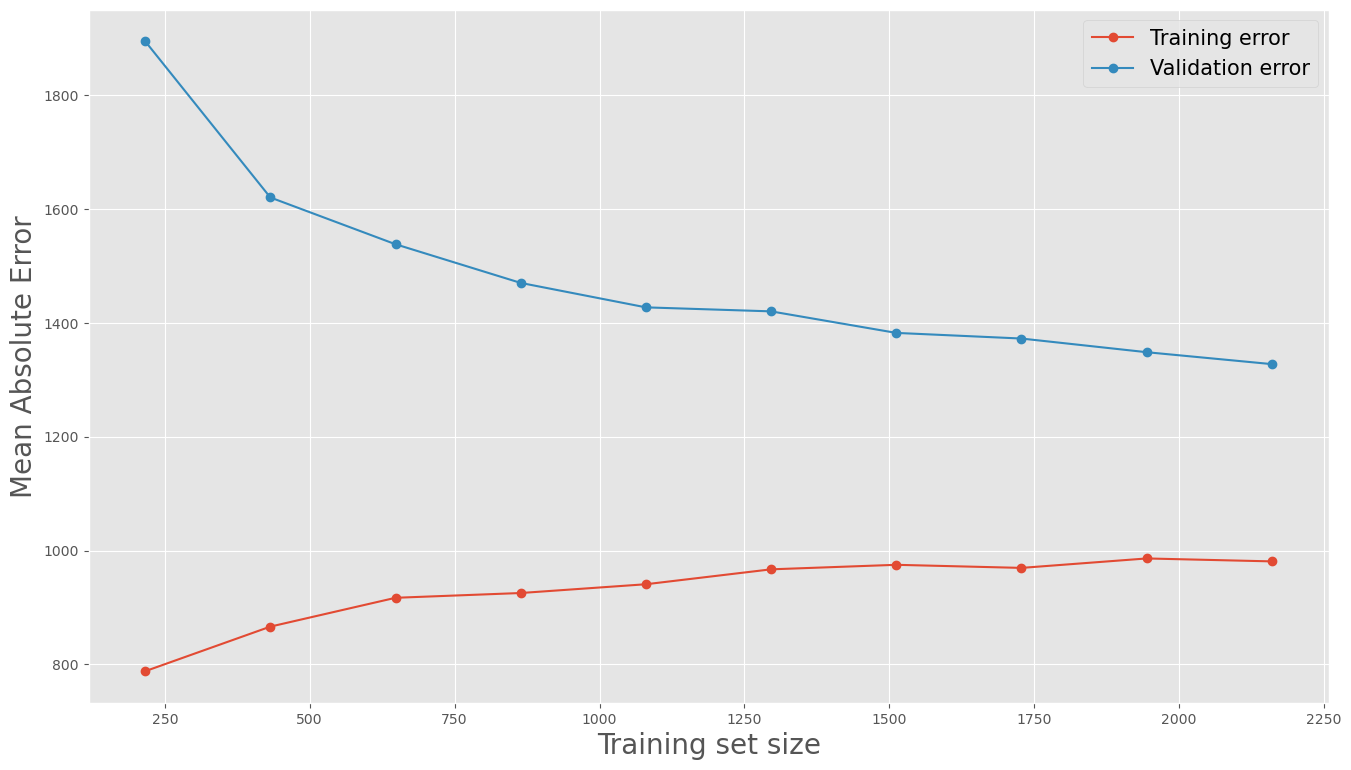

In [24]:
########### Plot Learning Curve ###########

plt.figure(figsize=(16, 9))
plt.plot(train_sizes, train_scores_mean, 'o-',  label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation error')
plt.xlabel('Training set size', fontsize = 20)
plt.ylabel('Mean Absolute Error', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.rc('xtick', labelsize='17')
plt.rc('ytick', labelsize='17')
plt.rc('axes', titlesize='15')
plt.show()

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

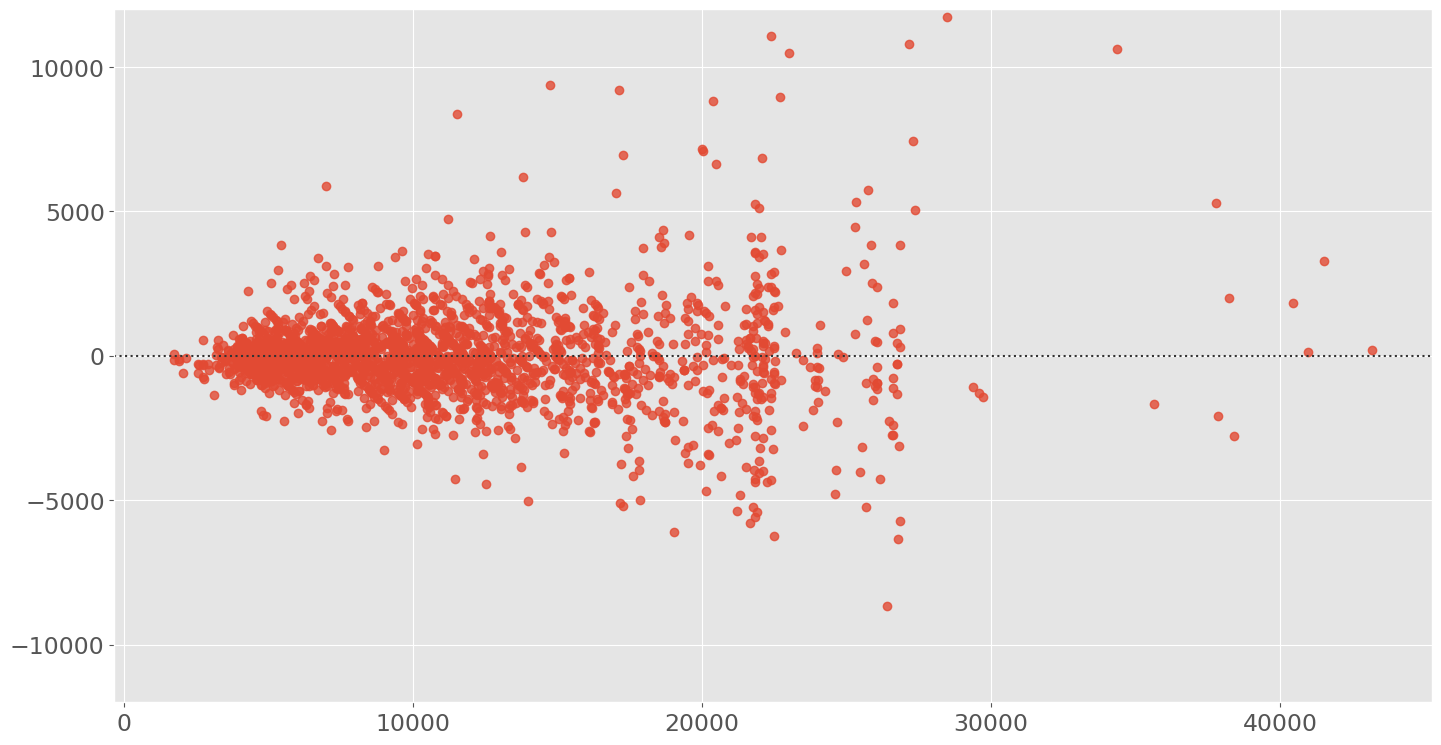

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

########### Calculate Residuals ###########

residuals_test = y_test - y_pred_ens_test_inv
residuals_train = y_train - y_pred_ens_train_inv

r2train = r2_score(y_train_log, y_pred_ens_train)
r2test = r2_score(y_test_log, y_pred_ens_test)

########### Plot Residuals ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_ens_train_inv, y=residuals_train, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Train'}, label='Train Set')
sns.residplot(x= y_pred_ens_test_inv, y=residuals_test, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual Test'}, label='Test Set')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = residuals_train, kde=True,stat = 'percent',  label='Train Residuals', alpha=0.5, ax = ax_hist)
sns.histplot(y = residuals_test, kde=True, stat = 'percent', label='Test Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")
ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Train: {:.3f}'.format(r2train),
    r'R$^2$ Test: {:.3f}'.format(r2test),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

print("r2 train:", r2train)
print("r2 test:", r2test)

In [ ]:
########### Plot Errors ###########

plt.figure(figsize=(15, 9))
plt.scatter(y_train, y_pred_ens_train_inv, alpha=0.5, label='Train Set')
plt.scatter(y_test, y_pred_ens_test_inv, alpha=0.5, label='Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'purple', linewidth=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'green',  linewidth=1)
plt.legend(loc='best', fontsize = 15)
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.show()

In [ ]:
########### Plot Residuals ###########

plt.figure(figsize=(15, 9))
sns.histplot(residuals_test, alpha = 0.5, kde=True, stat='percent', label = 'Test Set')
sns.histplot(residuals_train, alpha = 0.5, kde=True, stat='percent', label = 'Train Set')
plt.legend(loc='best', fontsize = 15)
plt.xlim(-10000, 10000)
plt.xlabel('Residuals', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)

plt.show()

## **Alternative Method: KNN Regressor**

In [ ]:
########### parameter grid ###########

param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 13],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'regressor__leaf_size': [20, 30, 40, 50],
    'regressor__p': [1, 2]
}

########### Initialise base model ###########

knn_model = KNeighborsRegressor(algorithm = 'brute')

########### Pipeline for base model ###########

model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('regressor', knn_model)
])

########### Random Search for best parameters ###########

random_search_knn = RandomizedSearchCV(estimator=model_knn, param_distributions=param_grid_knn, n_iter=200, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fit for Search ###########

random_search_knn.fit(X_train, y_train_log)

########### Set Parameters ###########

best_params_knn = random_search_knn.best_params_
best_knn = model_knn.set_params(**best_params_knn)

start = time.time()
best_knn.fit(X_train, y_train_log) ########### Fit model
stop = time.time()

########### Predict Prices ###########

y_pred_knn = best_knn.predict(X_test)

y_pred_knn_inv = target_transformer_log.inverse_transform(y_pred_knn.reshape(-1, 1)).reshape(-1)

########### Cross Validation with RMSE ###########

cv_scores_knn_rmsle = cross_val_score(best_knn, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for KNN: ")
print(f"Best parameters: {best_params_knn}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_knn_rmsle}")
print(f"Mean RMSE: {-cv_scores_knn_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_knn_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_knn_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_knn_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_knn))
print('Training Time:', stop-start)

joblib.dump(best_knn, "knn_model.pkl")
# shutil.copyfileobj(open("knn_model.pkl", "rb"), gzip.open("knn_model.pkl.gz", "wb"))
# os.remove("knn_model.pkl")



Metrics for KNN: 

Best parameters: {'regressor__weights': 'distance', 'regressor__p': 1, 'regressor__n_neighbors': 9, 'regressor__leaf_size': 30, 'regressor__algorithm': 'brute'}

Cross-Validation RMSE Scores: [2377.92342683 3591.76083688 2403.09033469 2326.03507088 2490.74604856 2172.2016863  2545.23792788 2467.29637138 2809.09758649 1971.88264244]

Mean RMSE: 2515.5271932342266

Standard Deviation of RMSE: 415.83547059024744

MSE: 5167510.12

MAE: **1418.12**

R2-Score: **0.877**

Training Time: 0.015s

In [ ]:
########### Predict Prices for testing and training ###########

y_pred_knn_test = best_knn.predict(X_test)
y_pred_knn_test_inv = target_transformer_log.inverse_transform(y_pred_knn_test.reshape(-1, 1)).reshape(-1)
y_pred_knn_train = best_knn.predict(X_train)
y_pred_knn_train_inv = target_transformer_log.inverse_transform(y_pred_knn_train.reshape(-1, 1)).reshape(-1)

########### Plot Errors ###########

plt.figure(figsize=(15, 9))
plt.scatter(y_train, y_pred_knn_train_inv, alpha=0.5, label='Train Set')
plt.scatter(y_test, y_pred_knn_test_inv, alpha=0.5, label='Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'purple', linewidth=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'green',  linewidth=1)
plt.legend(loc = 'best', fontsize = 15)
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.show()
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_knn_test_inv))
print('R2-Score Test: %.2f' % r2_score(y_test_log, y_pred_knn_test))
print('R2-Score Train: %.2f' % r2_score(y_train_log, y_pred_knn_train))

MAE: 1418.09
R2-Score Test: 0.88
R2-Score Train: 0.99

In [ ]:
########### r2 scores ###########

r2trainknn = r2_score(y_train_log, y_pred_knn_train)
r2testknn = r2_score(y_test_log, y_pred_knn_test)

########### Residuals ###########

residuals_test_knn = y_test - y_pred_knn_test_inv
residuals_train_knn = y_train - y_pred_knn_train_inv

########### Residuals Plot ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_knn_train_inv, y=residuals_train_knn, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Train'}, label='Train Set')
sns.residplot(x= y_pred_knn_test_inv, y=residuals_test_knn, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual Test'}, label='Test Set')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = y_train - np.round(y_pred_knn_train_inv,10), kde=True,stat = 'percent',  label='Train Residuals', alpha=0.5, ax = ax_hist, bins = 200)
sns.histplot(y = residuals_test_knn, kde=True, stat = 'percent', label='Test Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")
ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Train: {:.3f}'.format(r2trainknn),
    r'R$^2$ Test: {:.3f}'.format(r2testknn),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

print("r2 train:", r2trainknn)
print("r2 test:", r2testknn)

In [ ]:
########### Plot Resiudals ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_ens_test_inv, y=residuals_test, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Ensemble'}, label='Ensemble')
sns.residplot(x= y_pred_knn_test_inv, y=residuals_test_knn, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual kNN'}, label='kNN Regressor')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = -residuals_test, kde=True,stat = 'percent',  label='Ensemble Residuals', alpha=0.5, ax = ax_hist)
sns.histplot(y =-residuals_test_knn, kde=True, stat = 'percent', label='kNN Regressor Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")

ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Ensemble: {:.3f}'.format(r2test),
    r'R$^2$ kNN Regressor: {:.3f}'.format(r2testknn),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

In [ ]:
########### Predicted vs actual ###########

plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ens_test_inv, alpha=0.5, label='Ensemble')
plt.scatter(y_test, y_pred_knn_test_inv, alpha=0.5, label='kNN')
plt.plot([0, 50000], [0, 50000], '--')
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.show()

In [ ]:
########### Plot Residuals ###########

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_ens_test_inv, residuals_test, alpha=0.5, label='Ensemble Residuals')
plt.scatter(y_pred_knn_test_inv, residuals_test_knn, alpha=0.5, label='KNN Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
########### Plot Residuals ###########

plt.figure(figsize=(15, 9))
sns.histplot(residuals_test, kde=True,stat = 'percent',  label='Ensemble Residuals', alpha=0.5)
sns.histplot(residuals_test_knn, kde=True, stat = 'percent', label='kNN Regressor Residuals', alpha=0.5)
plt.xlim(-10000, 10000)
plt.xlabel('Residuals', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)

plt.legend(loc='best', fontsize = 15)
plt.show()

In [ ]:
########### Plot Box Plot for Cross Vals ###########

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.boxplot(y=np.abs(cv_scores_ensemble_rmse),ax = axes[0])
sns.boxplot(y=np.abs(cv_scores_knn_rmsle),ax = axes[1])
axes[0].set_title('Ensemble', fontsize = 18)
axes[1].set_title('kNN Regressor', fontsize = 18)

axes[0].set_ylim(3700, 1500)
axes[1].set_ylim(3700, 1500)
axes[0].set_ylabel('Cross-Validation RMSE', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.show()

In [ ]:
########### Predict prices for whole dataset and visualise ###########

df_True_pred = X_test
df_True_pred['True Prices [€]'] = y_test
df_True_pred['Predicted Prices [€]'] = y_pred_ens_test_inv
df_True_pred['Difference [€]'] = np.abs(residuals_test)
df_True_pred.rename = residuals_test
df_True_pred = df_True_pred[['Brand', 'Bike', 'Category', 'Power [hp]', 'Displacement [ccm]', 'Torque [Nm]', 'Mileage [km]', 'Age [a]', 'True Prices [€]', 'Predicted Prices [€]', 'Difference [€]']]
df_True_pred.sort_values(by = 'Difference [€]', ascending=False).head(10).style.format({'Power [hp]': "{:,.0f}", 'Displacement [ccm]': "{:,.0f}", 'Torque [Nm]': "{:,.0f}", 'Mileage [km]': "{:,.0f}", 'True Prices [€]': "{:,.2f} €", 'Predicted Prices [€]': "{:,.2f} €", 'Difference [€]': "{:,.2f} €"})

In [ ]:
########### For Variable Importance ###########

param_grid_xgbtree = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__learning_rate': [0.03, 0.05, 0.08],
    'regressor__max_depth': [4, 5, 6],
    'regressor__min_child_weight': [2, 3, 4],
    'regressor__subsample': [0.4, 0.6, 0.7],
    'regressor__colsample_bytree': [0.3, 0.6, 0.8],
    'regressor__gamma': [0, 0.1, 0.3, 0.5],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1]
}


extra_tree_model2 = ExtraTreesRegressor()

model_extratree2 = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', extra_tree_model2)
])

model_extratree2.fit(X_train, y_train_log.ravel())

preprocessor_std.fit(X_train)

num_features_out2 = preprocessor_std.transformers_[0][1].named_steps['scaler'].get_feature_names_out(num_features)
cat_features_out2 = preprocessor_std.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features_)
feature_names2 = np.concatenate([num_features_out2, cat_features_out2])
selected_features2 = model_extratree2.named_steps['feature_selection'].get_support()
selected_feature_names2 = feature_names2[selected_features2]

y_pred_xgbtree2 = model_extratree2.predict(X_test)

y_pred_xgbtree2_inv = target_transformer_log.inverse_transform(y_pred_xgbtree2.reshape(-1, 1)).reshape(-1)

cv_scores_xgbtree2_rmsle = cross_val_score(model_extratree2, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

print("Metrics for XGBoost Tree: ")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgbtree2_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgbtree2_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgbtree2_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgbtree2_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgbtree2_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgbtree2))

In [ ]:
########### Plot Importance ###########

xgb_model3 = model_extratree2.named_steps['regressor']

importances2 = xgb_model3.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names2,
    'importance': importances2
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='magma', hue = 'feature')
plt.xlabel('Importance', fontsize = 20)
plt.ylabel('Feature', fontsize = 20)
plt.show()